In [77]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2, f_classif, VarianceThreshold, RFE, SelectFromModel, SequentialFeatureSelector
from scipy.stats import ttest_ind
from mrmr import mrmr_classif
import sklearn_relief as relief
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state
from sklearn.linear_model import Ridge
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import multiprocessing
import pickle
import xgboost as xgb

# Other functions 

## Data availability per class 

In [2]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha='center')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs) 

In [3]:
def data_availability_func(data, name=''):

    X = data.drop(['Type'],axis=1)
    y = data['Type']
    y = y.astype('int')

    value_counts = y.value_counts().sort_index(ascending=True)
    value_counts_df = pd.DataFrame({'Type': value_counts.index, 'Quantity': value_counts.values})

    bplot = sns.barplot(x='Type', y='Quantity', data = value_counts_df, color='forestgreen')
    bplot.set(title='Dostępność danych ' + str(name), xlabel='Klasa', ylabel='Liczebność')
    # bplot.set_ylim(0, 140)
    show_values_on_bars(bplot)
    plt.show()

In [4]:
def data_availability_func1(datasets, names):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 14))
    fig.suptitle('Dostępność danych', fontsize=16)

    for i, (data, name, ax) in enumerate(zip(datasets, names, axes.flatten())):
        X = data.drop(['Type'], axis=1)
        y = data['Type']
        y = y.astype('int')

        value_counts = y.value_counts().sort_index(ascending=True)
        value_counts_df = pd.DataFrame({'Type': value_counts.index, 'Quantity': value_counts.values})

        bplot = sns.barplot(x='Type', y='Quantity', data=value_counts_df, color='forestgreen', ax=ax)
        bplot.set(title=f'({chr(65 + i)}) {str(name)}', xlabel='Klasa', ylabel='Liczebność')
        bplot.set_ylim(0, 150)
        # bplot.set_ylim(0, 140)
        show_values_on_bars(bplot)

    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.tight_layout()
    plt.show()

In [5]:
def feature_histogram(data, feature_name=''):
    # column_name = '101_at'

    plt.hist(data[feature_name], bins=20, color='blue', alpha=0.7)
    plt.title('Histogram genu {}'.format(feature_name))
    plt.xlabel('Wartość ekspresji genu')
    plt.ylabel('Częstość')
    plt.show()

In [6]:
def compare_datasets(df, df1):
    set1 = set(df.columns)
    set2 = set(df1.columns)
    verification = len(set1.intersection(set2)) / len(set1.union(set2)) * 100
    print(f"The two dataframes have {verification:.2f}% of column names in common")

# Data preprocessing

- Typically expression values in microarray data will be log-transformed, so there might be some negative values if values <1
- Log2 is used when normalizing the expression of genes because it aids in calculating fold change, which measures the up-regulated vs down-regulated genes between samples. Log2 measured data is also closer to the biologically-detectable changes.

## Lung cancer 

In [104]:
# Lung-cancer
df_lung_cancer = pd.read_csv('datasets/Multiclass/Lung-Cancer.csv', index_col=0)
X_lung_cancer = df_lung_cancer.drop(['Type'],axis=1)
y_lung_cancer = df_lung_cancer.Type


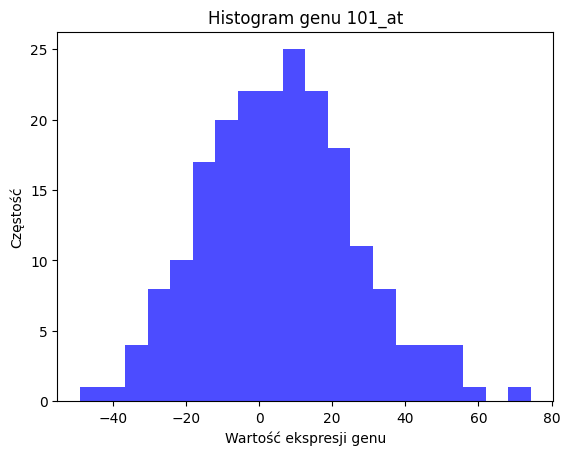

In [105]:
feature_histogram(X_lung_cancer, feature_name='101_at')

In [106]:
imputer = SimpleImputer(strategy='mean')
X_imputer_lung_cancer = imputer.fit_transform(X_lung_cancer)
df_normalized_lung_cancer = pd.DataFrame(X_imputer_lung_cancer, index=df_lung_cancer.index, columns=X_lung_cancer.columns)

# scaler = MinMaxScaler(feature_range=(0,1))
# X_scaled_lung_cancer = scaler.fit_transform(df_normalized_lung_cancer)
# df_normalized_lung_cancer = pd.DataFrame(X_scaled_lung_cancer, index=df_lung_cancer.index, columns=X_lung_cancer.columns)

type_col = df_lung_cancer['Type']
df_normalized_lung_cancer.insert(loc=0, column='Type', value=type_col)

In [107]:
df_normalized_lung_cancer

,Type,AFFX-MurIL2_at,AFFX-MurIL10_at,AFFX-MurIL4_at,AFFX-MurFAS_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,...,100_g_at,101_at,102_at,103_at,104_at,105_at,106_at,107_at,108_g_at,109_at
Samples,,,,,,,,,,,,,,,,,,,,,
AD-043T2-A7-1,1,-18.600,10.54,0.010,19.440,-16.980,-27.50,-1.600,38.88,-29.120,...,120.00,8.110,33.210,30.780,47.80,1.630,17.020,13.780,-103.49,76.980
AD-111T2-A8-1,1,9.120,9.12,10.180,29.290,-4.680,-1.50,-3.620,20.80,-13.180,...,63.27,15.490,27.170,26.110,45.22,10.180,69.640,-24.850,-34.41,105.730
AD-114T1-A9-1 *,1,-2.175,-2.21,-0.060,6.320,-1.775,-16.53,-3.610,16.41,-17.970,...,67.44,14.610,10.875,10.615,35.14,1.745,29.710,10.465,-42.63,73.735
AD-115T1-A12-1 *,1,-1.540,21.75,5.835,23.815,-24.785,-12.89,-4.485,19.50,-21.445,...,133.94,9.615,27.355,30.860,48.71,10.355,40.845,54.615,-71.38,65.435
AD-118t1-A13-1,1,-9.070,3.08,-1.980,17.260,-10.090,-15.15,-18.190,13.21,-13.130,...,99.23,-14.140,23.340,6.120,33.46,-10.090,40.550,16.250,-48.59,39.540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COID-COID5t1-A342-6,5,35.140,106.16,52.280,65.340,27.790,33.50,95.540,93.09,14.730,...,289.93,74.320,77.580,73.500,76.77,48.200,71.870,143.720,41.67,118.410
COID-COID6t1-A343-6,5,-21.150,-31.20,-11.820,8.280,-24.740,-29.77,3.970,21.92,-31.200,...,200.37,-16.130,11.150,-6.080,35.57,-3.210,24.070,-56.310,-43.40,65.030
COID-COID7t1-A344-6,5,26.900,10.44,18.230,33.830,-11.220,-4.29,19.970,14.77,-10.350,...,174.35,41.630,26.900,34.700,76.30,6.970,32.100,-28.540,0.04,71.970


In [108]:
df_normalized_lung_cancer  = df_normalized_lung_cancer[~(df_normalized_lung_cancer['Type'] == 3)]
df_normalized_lung_cancer.loc[df_normalized_lung_cancer['Type'] == 4, 'Type'] = 3
df_normalized_lung_cancer.loc[df_normalized_lung_cancer['Type'] == 5, 'Type'] = 4

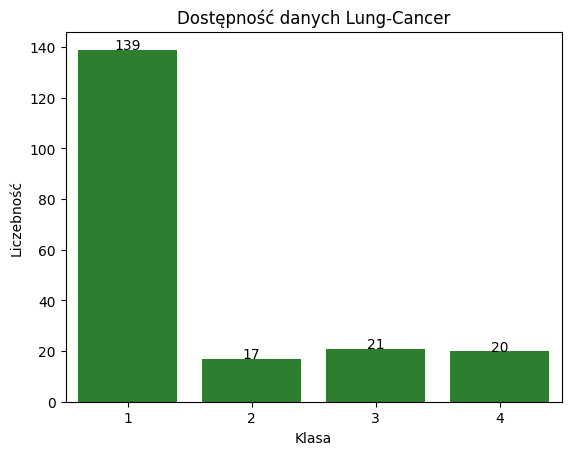

In [109]:
data_availability_func(df_normalized_lung_cancer, name='Lung-Cancer')

## SRBCT

In [13]:
# SRBCT
df_SRBCT = pd.read_csv('datasets/Multiclass/SRBCT.csv', skiprows=2314, index_col=0)
df_SRBCT = df_SRBCT.reset_index(drop=True)
df_SRBCT.index.name = 'Samples'
df_SRBCT.columns = df_SRBCT.columns.str.replace(' ', '')
# df_SRBCT.columns = df_SRBCT.iloc[0]
X_SRBCT = df_SRBCT.drop(['Type'],axis=1)
y_SRBCT = df_SRBCT.Type

In [14]:
X_SRBCT

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene2299,gene2300,gene2301,gene2302,gene2303,gene2304,gene2305,gene2306,gene2307,gene2308
Samples,,,,,,,,,,,,,,,,,,,,,
0,3.2025,0.0681,1.0460,0.1243,0.4941,3.1207,3.7106,1.8416,1.2607,2.9001,...,0.7653,1.6679,0.1493,0.6918,1.4151,0.2756,0.1521,0.3175,0.7240,0.2044
1,1.6547,0.0710,1.0409,0.0520,0.2045,2.1609,2.4452,1.1473,0.7371,1.9989,...,1.0665,3.6014,0.3048,1.7957,1.0701,0.2688,0.1932,0.4140,1.2708,0.2990
2,3.2779,0.1160,0.8926,0.1014,0.2818,1.9773,3.2590,1.4106,0.9548,2.0775,...,1.2674,1.5152,0.2382,0.8720,0.6819,0.3221,0.2156,0.3227,1.2142,0.2230
3,1.0060,0.1906,0.4302,0.1035,0.2984,1.6804,5.8901,0.2958,0.7381,1.6610,...,0.4743,1.0282,0.1049,0.5632,1.2264,0.8123,0.2758,0.3016,0.7235,0.0871
4,2.7098,0.2367,0.3693,0.2190,0.3711,1.7800,3.2376,0.6769,0.8546,0.6808,...,0.7039,0.5961,0.0707,0.4001,1.5271,0.4084,0.6412,0.3552,1.3928,0.2157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.6403,0.2515,1.3489,0.0646,0.2302,2.6957,7.8286,1.3432,2.1532,1.5941,...,0.5789,0.1715,0.6870,0.2249,0.6267,0.3742,0.3711,1.2332,0.8234,0.3209
79,0.6729,0.3038,2.0071,0.1553,0.2691,2.1064,5.8282,2.8124,2.2321,2.5947,...,0.3314,0.3845,0.6450,0.4294,0.6889,1.0609,0.2984,0.8024,1.5715,0.3265
80,0.8249,0.3454,1.2253,0.1277,0.2764,1.9422,10.5790,1.3557,2.6605,0.9183,...,1.5725,0.1166,0.8923,0.1361,0.5169,0.4861,0.1485,1.1742,0.7052,0.2799


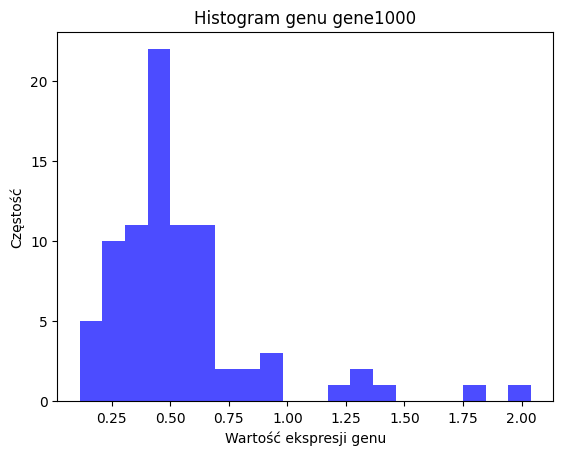

In [15]:
feature_histogram(X_SRBCT, feature_name='gene1000')

In [16]:
X_SRBCT_log = np.log2(X_SRBCT)

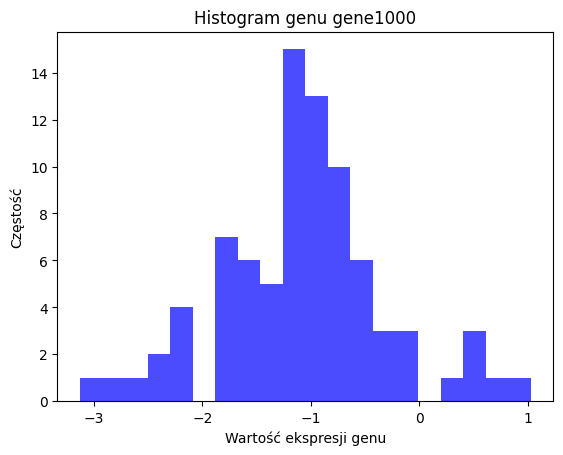

In [17]:
feature_histogram(X_SRBCT_log, feature_name='gene1000')

In [18]:

imputer = SimpleImputer(strategy='mean')
X_imputer_SRBCT = imputer.fit_transform(X_SRBCT_log)
df_normalized_SRBCT = pd.DataFrame(X_imputer_SRBCT, index=df_SRBCT.index, columns=X_SRBCT.columns)
    
# scaler = MinMaxScaler(feature_range=(0,1))
# X_scaled_SRBCT = scaler.fit_transform(df_normalized_SRBCT)
# df_normalized_SRBCT = pd.DataFrame(X_scaled_SRBCT, index=df_SRBCT.index, columns=X_SRBCT.columns)

type_col = df_SRBCT['Type']
df_normalized_SRBCT.insert(loc=0, column='Type', value=type_col)

In [19]:
df_normalized_SRBCT

,Type,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,...,gene2299,gene2300,gene2301,gene2302,gene2303,gene2304,gene2305,gene2306,gene2307,gene2308
Samples,,,,,,,,,,,,,,,,,,,,,
0,1,1.679199,-3.876201,0.064883,-3.008102,-1.017125,1.641870,1.891652,0.880960,0.334225,...,-0.385903,0.738033,-2.743714,-0.531573,0.500904,-1.859352,-2.716908,-1.655172,-0.465938,-2.290533
1,1,0.726570,-3.816037,0.057831,-4.265345,-2.289827,1.111632,1.289952,0.198243,-0.440068,...,0.092884,1.848558,-1.714065,0.844546,0.097746,-1.895395,-2.371833,-1.272297,0.345737,-1.741783
2,1,1.712772,-3.107803,-0.163914,-3.301870,-1.827256,0.983532,1.704429,0.496309,-0.066730,...,0.341872,0.599508,-2.069755,-0.197600,-0.552368,-1.634419,-2.213571,-1.631735,0.280006,-2.164884
3,1,0.008630,-2.391380,-1.216921,-3.272297,-1.744681,0.748805,2.558292,-1.757306,-0.438112,...,-1.076128,0.040121,-3.252913,-0.828281,0.294430,-0.299915,-1.858306,-1.729292,-0.466935,-3.521183
4,1,1.438186,-2.078868,-1.437135,-2.190997,-1.430120,0.831877,1.694925,-0.562985,-0.226679,...,-0.506558,-0.746374,-3.822146,-1.321567,0.610795,-1.291945,-0.641154,-1.493297,0.477988,-2.212902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,3,-0.643180,-1.991370,0.431783,-3.952322,-2.119040,1.430660,2.968754,0.425674,1.106482,...,-0.788614,-2.543720,-0.541618,-2.152644,-0.674153,-1.418119,-1.430120,0.302407,-0.280335,-1.639804
79,3,-0.571536,-1.718806,1.005112,-2.686870,-1.893786,1.074779,2.543050,1.491802,1.158402,...,-1.593354,-1.378944,-0.632629,-1.219606,-0.537634,0.085289,-1.744681,-0.317606,0.652142,-1.614845
80,3,-0.277709,-1.533660,0.293135,-2.969170,-1.855170,0.957692,3.403131,0.439038,1.411697,...,0.653060,-3.100360,-0.164399,-2.877261,-0.952043,-1.040675,-2.751465,0.231678,-0.503896,-1.837017


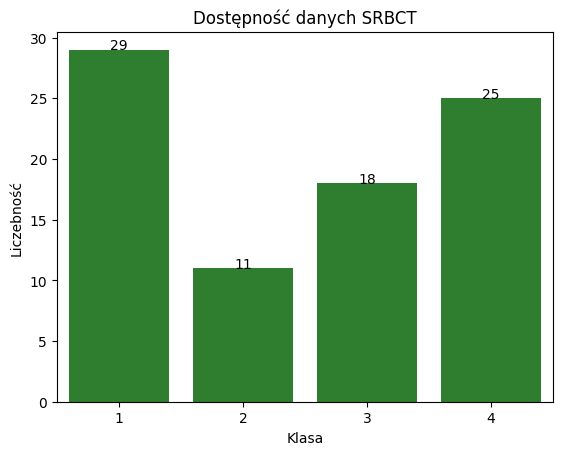

In [20]:
data_availability_func(df_normalized_SRBCT, name='SRBCT')

## BarretNP

In [21]:

# BarretNP
df_NablonekPlaski = pd.read_csv('datasets/Multiclass/NablonekPlaski.csv', index_col=0).T
df_NablonekPlaski.index.name = 'Samples'
X_NablonekPlaski = df_NablonekPlaski.drop(['Type'],axis=1)
y_NablonekPlaski = df_NablonekPlaski.Type

In [22]:
df_NablonekPlaski

,Type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
Samples,,,,,,,,,,,,,,,,,,,,,
bp10,1.0,9.30779,7.66326,2.90366,6.89238,2.14964,3.54694,3.06987,2.65436,3.88736,...,12.66206,12.42075,14.41286,14.29935,2.13006,2.59389,2.61577,2.74996,2.33088,2.87131
bp12,1.0,9.20716,7.12334,2.89841,6.55691,2.15963,3.54695,3.09391,2.65834,3.99529,...,12.67340,12.54158,14.69780,14.45778,2.14197,2.67745,2.64379,2.80187,2.34563,2.84700
bp13,1.0,9.09143,7.11473,2.90284,6.41455,2.15493,3.54703,3.10470,2.70951,3.85735,...,12.60315,12.50028,14.52968,14.30830,2.13743,2.59265,2.64270,2.79114,2.35010,2.80795
bp131,1.0,9.55373,7.34332,2.94383,6.44975,2.09056,3.52331,2.97376,2.51816,4.28786,...,12.21628,11.84917,14.10974,13.95807,2.07472,2.53926,2.44792,2.57783,2.27148,2.62954
bp133,1.0,9.20364,7.40192,2.91570,6.52973,2.13779,3.53894,3.03414,2.56772,3.70989,...,12.81756,12.46851,14.30653,14.13344,2.11643,2.56862,2.56497,2.70334,2.31095,2.74242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n72,3.0,8.64405,7.17329,2.90897,6.56480,2.15272,3.55222,3.06615,2.67298,3.49624,...,12.69461,12.57983,14.50801,14.29646,2.13019,2.58399,2.60902,2.74347,2.32687,2.78411
n74,3.0,9.00705,7.14653,3.01354,6.52672,2.11478,4.13387,3.00640,2.54720,4.94477,...,12.38271,12.18098,14.37551,14.03206,2.09095,2.55304,2.55007,2.66643,2.28830,2.72441
n79,3.0,8.59677,6.89650,2.89105,6.49177,2.13083,3.53371,3.04457,2.65238,3.82254,...,12.36847,12.00618,14.30877,14.03991,2.10822,2.56057,2.56574,2.70763,2.30510,2.74851


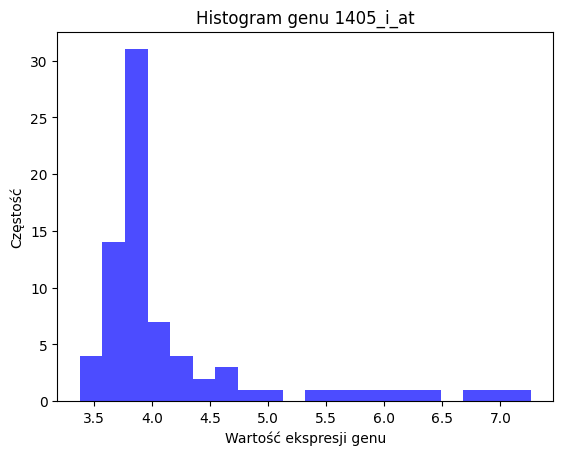

In [23]:
feature_histogram(X_NablonekPlaski, feature_name='1405_i_at')

In [24]:

imputer = SimpleImputer(strategy='mean')
X_imputer_NablonekPlaski = imputer.fit_transform(X_NablonekPlaski)
df_normalized_NablonekPlaski = pd.DataFrame(X_imputer_NablonekPlaski, index=df_NablonekPlaski.index, columns=X_NablonekPlaski.columns)
    
# scaler = MinMaxScaler(feature_range=(0,1))
# X_scaled_NablonekPlaski = scaler.fit_transform(X_NablonekPlaski)
# df_normalized_NablonekPlaski = pd.DataFrame(X_scaled_NablonekPlaski, index=df_NablonekPlaski.index, columns=X_NablonekPlaski.columns)

type_col = df_NablonekPlaski['Type']
df_normalized_NablonekPlaski.insert(loc=0, column='Type', value=type_col)


In [25]:
df_normalized_NablonekPlaski

,Type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
Samples,,,,,,,,,,,,,,,,,,,,,
bp10,1.0,9.30779,7.66326,2.90366,6.89238,2.14964,3.54694,3.06987,2.65436,3.88736,...,12.66206,12.42075,14.41286,14.29935,2.13006,2.59389,2.61577,2.74996,2.33088,2.87131
bp12,1.0,9.20716,7.12334,2.89841,6.55691,2.15963,3.54695,3.09391,2.65834,3.99529,...,12.67340,12.54158,14.69780,14.45778,2.14197,2.67745,2.64379,2.80187,2.34563,2.84700
bp13,1.0,9.09143,7.11473,2.90284,6.41455,2.15493,3.54703,3.10470,2.70951,3.85735,...,12.60315,12.50028,14.52968,14.30830,2.13743,2.59265,2.64270,2.79114,2.35010,2.80795
bp131,1.0,9.55373,7.34332,2.94383,6.44975,2.09056,3.52331,2.97376,2.51816,4.28786,...,12.21628,11.84917,14.10974,13.95807,2.07472,2.53926,2.44792,2.57783,2.27148,2.62954
bp133,1.0,9.20364,7.40192,2.91570,6.52973,2.13779,3.53894,3.03414,2.56772,3.70989,...,12.81756,12.46851,14.30653,14.13344,2.11643,2.56862,2.56497,2.70334,2.31095,2.74242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n72,3.0,8.64405,7.17329,2.90897,6.56480,2.15272,3.55222,3.06615,2.67298,3.49624,...,12.69461,12.57983,14.50801,14.29646,2.13019,2.58399,2.60902,2.74347,2.32687,2.78411
n74,3.0,9.00705,7.14653,3.01354,6.52672,2.11478,4.13387,3.00640,2.54720,4.94477,...,12.38271,12.18098,14.37551,14.03206,2.09095,2.55304,2.55007,2.66643,2.28830,2.72441
n79,3.0,8.59677,6.89650,2.89105,6.49177,2.13083,3.53371,3.04457,2.65238,3.82254,...,12.36847,12.00618,14.30877,14.03991,2.10822,2.56057,2.56574,2.70763,2.30510,2.74851


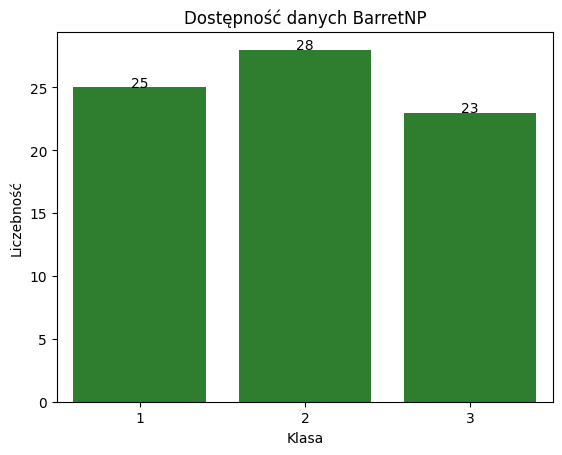

In [26]:
data_availability_func(df_normalized_NablonekPlaski, name='BarretNP')

## TOX-171

In [27]:

#  TOX-171
df_TOX_171 = pd.read_csv('datasets/Multiclass/TOX-171.csv', index_col=0).T
df_TOX_171.index.name = 'Samples'
X_TOX_171 = df_TOX_171.drop(['Type'],axis=1)
y_TOX_171 = df_TOX_171.Type

In [28]:
df_TOX_171

,Type,1000_at,1007_s_at,1008_f_at,1009_at,1011_s_at,1013_at,1014_at,1017_at,1019_g_at,...,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMTFRR/M11507_3_at,AFFX-HUMTFRR/M11507_5_at,AFFX-HUMTFRR/M11507_M_at,AFFX-hum_alu_at,AFFX-M27830_3_at,AFFX-YEL021w/URA3_at
Samples,,,,,,,,,,,,,,,,,,,,,
0,1.0,373.65,368.79,1550.87,4491.66,604.50,94.14,247.95,49.54,74.46,...,2594.09,795.13,1143.10,1203.66,1400.17,704.98,696.93,18131.59,242.74,58.56
1,1.0,499.84,218.57,989.16,4099.71,442.85,74.09,176.89,61.48,107.43,...,3036.28,999.55,1360.13,1462.37,1431.31,788.00,563.84,14562.46,188.32,106.71
2,1.0,474.83,447.26,1670.79,4343.63,363.91,93.34,228.56,64.52,116.49,...,3311.31,932.04,1573.32,1618.36,908.71,507.98,477.90,21018.33,370.85,129.86
3,1.0,391.48,126.34,1677.33,4736.90,484.28,77.97,186.04,45.85,127.98,...,2321.90,568.92,985.72,979.47,1854.13,916.37,895.86,21847.45,209.69,93.86
4,1.0,559.19,91.97,1658.66,4294.18,467.25,44.46,280.87,41.80,24.41,...,2411.67,556.57,887.45,1053.10,1332.09,698.93,721.38,21651.79,309.88,118.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,4.0,383.90,197.23,2020.32,3124.02,517.24,15.03,409.65,79.75,136.65,...,3866.17,1115.19,2514.76,1983.60,1531.30,602.40,805.19,21224.12,153.69,126.76
167,4.0,421.74,458.43,1638.74,3286.67,578.96,62.79,327.51,130.21,163.84,...,3817.44,1140.94,2603.41,2157.27,1537.88,533.84,564.66,20447.99,332.40,113.44
168,4.0,314.12,202.18,2099.85,4961.69,462.76,44.03,359.01,51.70,38.96,...,2434.59,735.42,1843.59,1370.28,1949.79,846.40,959.98,6785.61,62.21,79.53


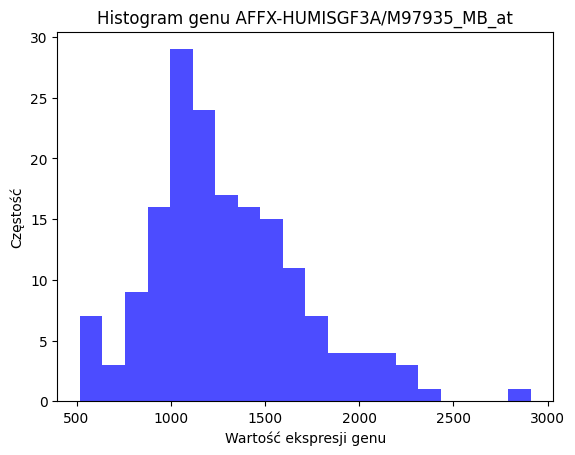

In [29]:
feature_histogram(X_TOX_171, feature_name='AFFX-HUMISGF3A/M97935_MB_at')

In [30]:
X_TOX_171_log = np.log2(X_TOX_171)

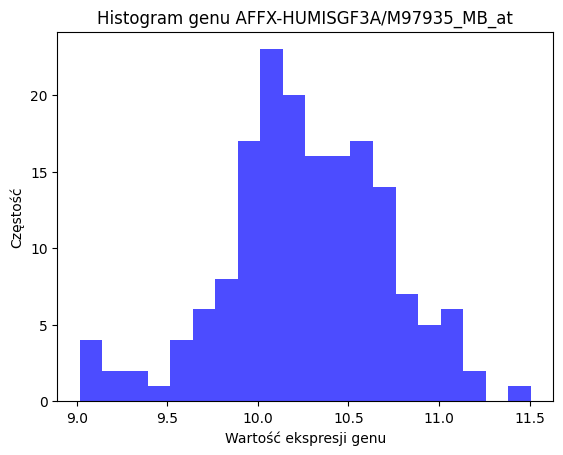

In [31]:
feature_histogram(X_TOX_171_log, feature_name='AFFX-HUMISGF3A/M97935_MB_at')

In [32]:
imputer = SimpleImputer(strategy='mean')
X_imputer_TOX_171 = imputer.fit_transform(X_TOX_171_log)
df_normalized_TOX_171 = pd.DataFrame(X_imputer_TOX_171, index=df_TOX_171.index, columns=X_TOX_171.columns)
    
# scaler = MinMaxScaler(feature_range=(0,1))
# X_scaled_TOX_171 = scaler.fit_transform(X_TOX_171)
# df_normalized_TOX_171 = pd.DataFrame(X_scaled_TOX_171, index=df_TOX_171.index, columns=X_TOX_171.columns)

type_col = df_TOX_171['Type']
df_normalized_TOX_171.insert(loc=0, column='Type', value=type_col)


In [33]:
df_normalized_TOX_171

,Type,1000_at,1007_s_at,1008_f_at,1009_at,1011_s_at,1013_at,1014_at,1017_at,1019_g_at,...,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMTFRR/M11507_3_at,AFFX-HUMTFRR/M11507_5_at,AFFX-HUMTFRR/M11507_M_at,AFFX-hum_alu_at,AFFX-M27830_3_at,AFFX-YEL021w/URA3_at
Samples,,,,,,,,,,,,,,,,,,,,,
0,1.0,8.545544,8.526656,10.598862,12.133033,9.239599,6.556736,7.953905,5.630522,6.218394,...,11.341013,9.635047,10.158736,10.233212,10.451386,9.461439,9.444870,14.146218,7.923268,5.871844
1,1.0,8.965323,7.771952,9.950060,12.001306,8.790674,6.211207,7.466709,5.942045,6.747253,...,11.568089,9.965135,10.409529,10.514093,10.483120,9.622052,9.139142,13.829966,7.557042,6.737552
2,1.0,8.891267,8.804970,10.706315,12.084686,8.507438,6.544424,7.836429,6.011675,6.864062,...,11.693186,9.864248,10.619596,10.660317,9.827676,8.988628,8.900565,14.359360,8.534692,7.020813
3,1.0,8.612795,6.981168,10.711951,12.209728,8.919698,6.284847,7.539469,5.518850,6.999775,...,11.181090,9.152082,9.945034,9.935857,10.856527,9.839786,9.807129,14.415177,7.712114,6.552439
4,1.0,9.127195,6.523091,10.695802,12.068167,8.868051,5.474436,8.133759,5.385431,4.609400,...,11.235817,9.120419,9.793522,10.040427,10.379476,9.449004,9.494616,14.402199,8.275566,6.884720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,4.0,8.584587,7.623735,10.980368,11.609188,9.014690,3.909773,8.678248,6.317413,7.094342,...,11.916689,10.123074,11.296205,10.953905,10.580541,9.234578,9.653185,14.373417,7.263879,6.985956
167,4.0,8.720210,8.840558,10.678371,11.682411,9.177320,5.972463,8.355395,7.024696,7.356144,...,11.898390,10.156007,11.346187,11.074991,10.586727,9.060264,9.141239,14.319671,8.376777,6.825786
168,4.0,8.295172,7.659496,11.036071,12.276616,8.854120,5.460415,8.487880,5.692092,5.283922,...,11.249463,9.522425,10.848302,10.420255,10.929103,9.725196,9.906861,12.728263,5.959075,6.313427


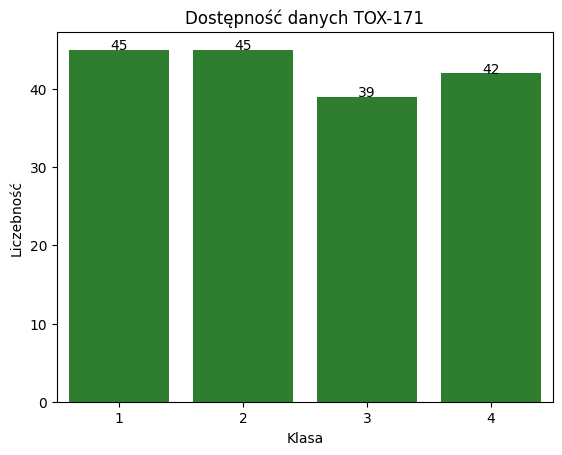

In [34]:
data_availability_func(df_normalized_TOX_171, name='TOX-171')

## GLA-BRA-180

In [35]:
# GLA_BRA_180
df_GLA_BRA_180 = pd.read_csv('datasets/Multiclass/GLA-BRA-180.csv', index_col=0).T
df_GLA_BRA_180.index.name = 'Samples'
X_GLA_BRA_180 = df_GLA_BRA_180.drop(['Type'],axis=1)
y_GLA_BRA_180 = df_GLA_BRA_180.Type


In [36]:
df_GLA_BRA_180

,Type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,90265_at,90610_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
Samples,,,,,,,,,,,,,,,,,,,,,
0,1.0,4701.5,282.7,769.6,1616.3,232.7,357.7,245.1,33.2,30.7,...,4767.9,453.4,585.5,724.2,476.0,215.8,1002.0,71.7,1524.7,318.9
1,1.0,4735.0,347.9,287.9,1527.2,204.8,336.5,186.2,22.9,57.1,...,3497.3,439.9,453.2,603.1,347.1,269.6,1017.2,33.0,1742.0,304.5
2,1.0,2863.9,355.0,199.0,1793.8,119.3,328.7,349.3,30.0,17.8,...,3490.2,200.0,370.6,641.4,419.3,269.5,745.8,51.0,1333.5,322.0
3,1.0,5350.2,319.9,182.8,1880.0,180.2,304.7,325.4,47.6,30.7,...,4604.1,565.1,501.2,579.7,289.4,205.6,959.7,165.1,1572.5,302.9
4,1.0,4789.4,294.2,204.3,1012.0,156.7,190.1,132.0,18.8,11.8,...,3939.1,395.4,439.6,523.0,408.0,240.4,996.8,48.7,1226.0,230.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,4.0,15361.6,651.3,266.0,1941.0,104.8,589.5,322.0,48.3,25.9,...,908.0,648.8,405.2,704.5,528.7,232.3,1638.7,28.1,9759.4,517.4
176,4.0,10148.3,417.7,314.5,1671.0,40.1,468.7,232.8,36.2,71.2,...,943.1,705.1,565.5,642.6,735.4,271.7,1354.1,265.8,3421.8,215.2
177,4.0,7848.6,340.2,240.5,1836.0,156.0,461.1,328.4,95.7,22.3,...,3286.8,593.1,400.9,614.3,426.6,237.7,1266.0,239.9,4022.3,325.5


In [37]:
len(df_GLA_BRA_180.columns.unique())

49152

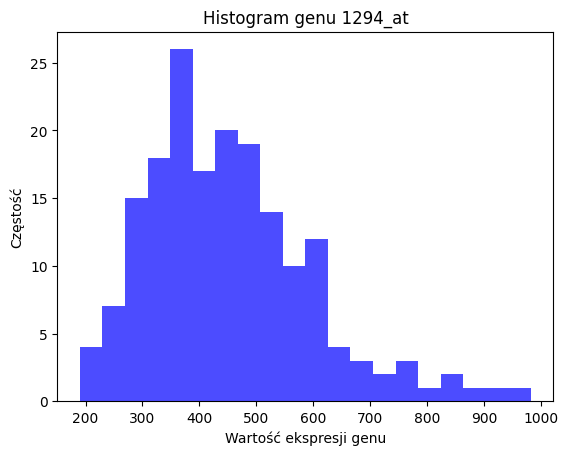

In [38]:
feature_histogram(X_GLA_BRA_180, feature_name='1294_at')

In [39]:
X_GLA_BRA_180_log = np.log2(X_GLA_BRA_180)

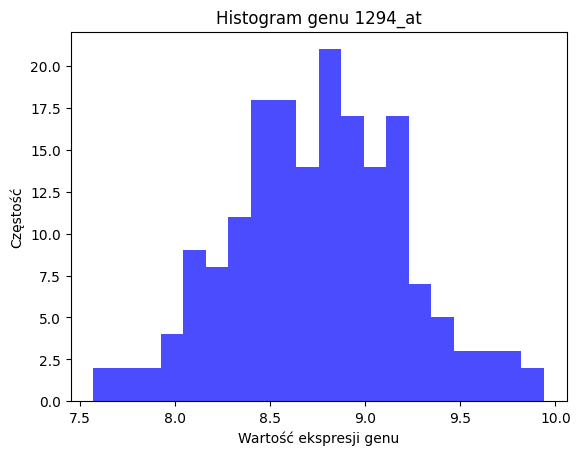

In [40]:
feature_histogram(X_GLA_BRA_180_log, feature_name='1294_at')

In [41]:
imputer = SimpleImputer(strategy='mean')
X_imputer_GLA_BRA_180 = imputer.fit_transform(X_GLA_BRA_180_log)
df_normalized_GLA_BRA_180 = pd.DataFrame(X_imputer_GLA_BRA_180, index=df_GLA_BRA_180.index, columns=X_GLA_BRA_180.columns)
    
# scaler = MinMaxScaler(feature_range=(0,1))
# X_scaled_GLA_BRA_180 = scaler.fit_transform(X_GLA_BRA_180)
# df_normalized_GLA_BRA_180 = pd.DataFrame(X_scaled_GLA_BRA_180, index=df_GLA_BRA_180.index, columns=X_GLA_BRA_180.columns)

type_col = df_GLA_BRA_180['Type']
df_normalized_GLA_BRA_180.insert(loc=0, column='Type', value=type_col)


In [42]:
df_normalized_GLA_BRA_180

,Type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,90265_at,90610_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
Samples,,,,,,,,,,,,,,,,,,,,,
0,1.0,12.198905,8.143128,9.587965,10.658479,7.862327,8.482606,7.937227,5.053111,4.940167,...,12.219138,8.824641,9.193525,9.500244,8.894818,7.753551,9.968667,6.163901,10.574310,8.316960
1,1.0,12.209149,8.442529,8.169424,10.576673,7.678072,8.394463,7.540709,4.517276,5.835419,...,11.772026,8.781032,8.824004,9.236253,8.439208,8.074677,9.990388,5.044394,10.766529,8.250298
2,1.0,11.483765,8.471675,7.636625,10.808803,6.898450,8.360628,8.448323,4.906891,4.153805,...,11.769094,7.643856,8.533719,9.325081,8.711839,8.074141,9.542645,5.672425,10.381002,8.330917
3,1.0,12.385377,8.321477,7.514122,10.876517,7.493455,8.251246,8.346070,5.572890,4.940167,...,12.168703,9.142362,8.969243,9.179163,8.176921,7.683696,9.906440,7.367196,10.618844,8.242698
4,1.0,12.225629,8.200653,7.674545,9.982994,7.291861,7.570615,7.044394,4.232661,3.560715,...,11.943650,8.627169,8.780048,9.030667,8.672425,7.909293,9.961160,5.605850,10.259743,7.847997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,4.0,13.907041,9.347178,8.055282,10.922584,6.711495,9.203348,8.330917,5.593951,4.694880,...,9.826548,9.341630,8.662490,9.460456,9.046306,7.859845,10.678336,4.812498,13.252577,9.015136
176,4.0,13.308950,8.706323,8.296916,10.706496,5.325530,8.872521,7.862947,5.177918,6.153805,...,9.881267,9.461684,9.143383,9.327777,9.522385,8.085871,10.403119,8.054197,11.740540,7.749534
177,4.0,12.938220,8.410239,7.909893,10.842350,7.285402,8.848936,8.359310,6.580447,4.478972,...,11.682468,9.212132,8.647099,9.262800,8.736740,7.892998,10.306062,7.906289,11.973805,8.346514


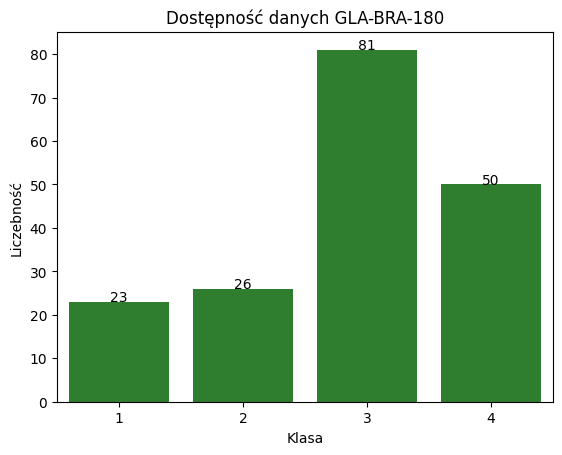

In [43]:
data_availability_func(df_normalized_GLA_BRA_180, name='GLA-BRA-180')

## CLL-SUB-111

In [44]:

# CLL_SUB_111
df_CLL_SUB_111 = pd.read_csv('datasets/Multiclass/CLL-SUB-111.csv', index_col=0).T
df_CLL_SUB_111.index.name = 'Samples'
X_CLL_SUB_111 = df_CLL_SUB_111.drop(['Type'],axis=1)
y_CLL_SUB_111 = df_CLL_SUB_111.Type


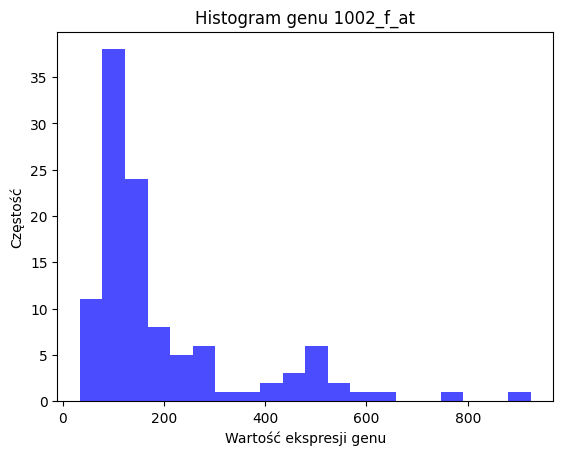

In [45]:
feature_histogram(X_CLL_SUB_111, feature_name='1002_f_at')

In [46]:
X_CLL_SUB_111_log = np.log2(X_CLL_SUB_111)

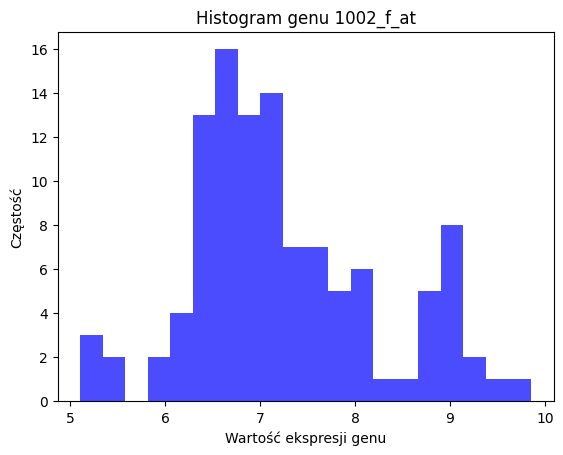

In [47]:
feature_histogram(X_CLL_SUB_111_log, feature_name='1002_f_at')

In [48]:

imputer = SimpleImputer(strategy='mean')
X_imputer_CLL_SUB_111 = imputer.fit_transform(X_CLL_SUB_111_log)
df_normalized_CLL_SUB_111 = pd.DataFrame(X_imputer_CLL_SUB_111, index=df_CLL_SUB_111.index, columns=X_CLL_SUB_111.columns)
    
# scaler = MinMaxScaler(feature_range=(0,1))
# X_scaled_CLL_SUB_111 = scaler.fit_transform(X_CLL_SUB_111)
# df_normalized_CLL_SUB_111 = pd.DataFrame(X_scaled_CLL_SUB_111, index=df_CLL_SUB_111.index, columns=X_CLL_SUB_111.columns)

type_col = df_CLL_SUB_111['Type']
df_normalized_CLL_SUB_111.insert(loc=0, column='Type', value=type_col)

In [49]:
df_normalized_CLL_SUB_111

,Type,1000_at,1001_at,1002_f_at,1003_s_at,1004_at,1005_at,1006_at,1007_s_at,1008_f_at,...,AFFX-MurIL2_at,AFFX-MurIL4_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-YEL002c/WBP1_at,AFFX-YEL021w/URA3_at,AFFX-YEL024w/RIP1_at
Samples,,,,,,,,,,,,,,,,,,,,,
0,1.0,12.151984,9.603756,9.048168,10.625653,12.113508,14.695268,6.767377,10.853645,11.177525,...,7.463058,7.748206,8.541747,8.535038,8.311290,8.175090,8.171372,7.610080,8.863201,9.487191
1,1.0,12.257045,9.896351,9.852695,9.251582,12.488286,14.626815,7.881077,11.982554,11.848008,...,8.285684,8.574359,9.376941,8.315204,8.289539,6.963174,7.657647,9.912783,10.068464,10.187074
2,1.0,12.777547,9.941075,9.310286,9.538550,12.785403,13.915123,7.464080,10.971251,11.500975,...,8.771499,7.928625,8.612699,8.591466,10.240912,9.955685,8.492086,6.810019,10.256919,8.711436
3,1.0,11.949390,9.283561,8.723176,11.255347,12.579752,13.060555,6.533361,11.772206,11.463984,...,7.748012,8.384015,8.235713,6.848573,8.984427,8.217948,8.666526,7.947771,9.116063,8.573708
4,1.0,12.065739,10.031182,9.032925,11.604968,12.544743,15.825388,7.648861,11.593890,14.268501,...,10.536166,8.481206,8.008686,7.559622,9.589453,8.682008,10.244413,9.679049,9.263689,8.884204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,3.0,12.085025,6.330236,9.060442,12.734753,13.628479,14.994733,6.066132,11.289830,12.136304,...,7.475879,6.272452,7.680374,6.419168,8.168637,5.989593,6.853634,7.130694,8.785260,6.592502
107,3.0,13.252195,9.571007,6.318787,11.243998,12.394127,13.740385,7.487848,11.603796,13.003792,...,7.645911,4.651454,7.603248,7.370129,6.766675,5.615034,6.572389,8.091462,8.005321,8.829399
108,3.0,12.387619,9.970376,7.039621,12.456900,12.704845,14.337856,7.322649,12.227456,13.046493,...,7.976513,7.073681,8.542784,7.323424,7.990773,4.836783,7.590617,7.856712,7.335774,8.654296


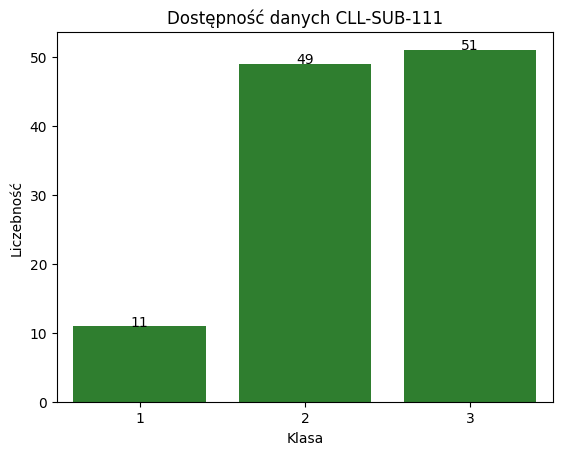

In [50]:
data_availability_func(df_normalized_CLL_SUB_111, name='CLL-SUB-111')

## data availability for each dataset

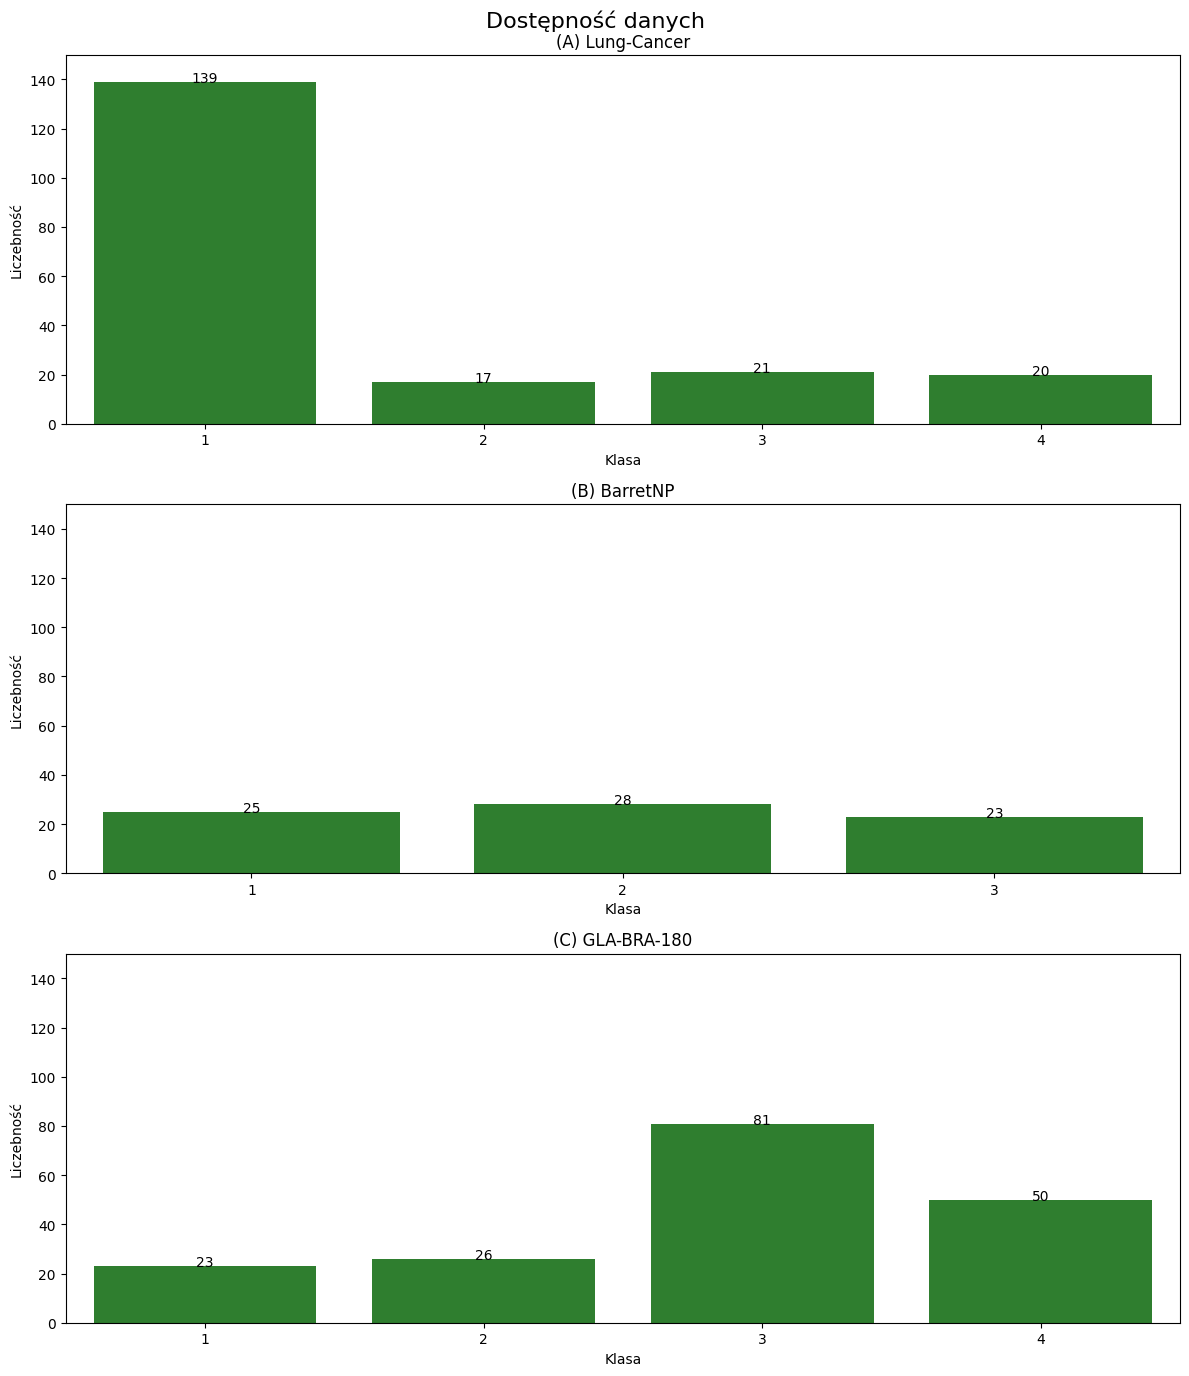

In [51]:
dataset_all = [df_normalized_lung_cancer, df_normalized_NablonekPlaski, df_normalized_GLA_BRA_180]
names_all = ['Lung-Cancer', 'BarretNP', 'GLA-BRA-180']

data_availability_func1(dataset_all, names_all)

## variance preprocessing selection 

In [110]:
print(df_normalized_lung_cancer.shape)
print(df_normalized_NablonekPlaski.shape)
print(df_normalized_GLA_BRA_180.shape)

(197, 12601)
(76, 22278)
(180, 49152)


In [111]:
def variance_threshold_func(data, threshold):
    X = data.drop(['Type'], axis=1)
    y = data['Type']

    selector = VarianceThreshold(threshold=threshold)

    selector.fit(X)
    selected_features = selector.get_support(indices=True)

    selected_feature_names = X.columns[selected_features]

    selected_features_list = selected_feature_names.to_list()

    filtered_var_threshold_df = data[['Type'] + selected_features_list]

    return filtered_var_threshold_df

In [112]:
df_normalized_lung_cancer_var = variance_threshold_func(df_normalized_lung_cancer, threshold=0.01)
df_normalized_NablonekPlaski_var = variance_threshold_func(df_normalized_NablonekPlaski, threshold=0.01)
df_normalized_GLA_BRA_180_var = variance_threshold_func(df_normalized_GLA_BRA_180, threshold=0.01)

In [113]:
print(df_normalized_lung_cancer_var.shape)
print(df_normalized_NablonekPlaski_var.shape)
print(df_normalized_GLA_BRA_180_var.shape)

(197, 12601)
(76, 14001)
(180, 49152)


In [114]:
df_normalized_lung_cancer_var

,Type,AFFX-MurIL2_at,AFFX-MurIL10_at,AFFX-MurIL4_at,AFFX-MurFAS_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,...,100_g_at,101_at,102_at,103_at,104_at,105_at,106_at,107_at,108_g_at,109_at
Samples,,,,,,,,,,,,,,,,,,,,,
AD-043T2-A7-1,1,-18.600,10.54,0.010,19.440,-16.980,-27.50,-1.600,38.88,-29.120,...,120.00,8.110,33.210,30.780,47.80,1.630,17.020,13.780,-103.49,76.980
AD-111T2-A8-1,1,9.120,9.12,10.180,29.290,-4.680,-1.50,-3.620,20.80,-13.180,...,63.27,15.490,27.170,26.110,45.22,10.180,69.640,-24.850,-34.41,105.730
AD-114T1-A9-1 *,1,-2.175,-2.21,-0.060,6.320,-1.775,-16.53,-3.610,16.41,-17.970,...,67.44,14.610,10.875,10.615,35.14,1.745,29.710,10.465,-42.63,73.735
AD-115T1-A12-1 *,1,-1.540,21.75,5.835,23.815,-24.785,-12.89,-4.485,19.50,-21.445,...,133.94,9.615,27.355,30.860,48.71,10.355,40.845,54.615,-71.38,65.435
AD-118t1-A13-1,1,-9.070,3.08,-1.980,17.260,-10.090,-15.15,-18.190,13.21,-13.130,...,99.23,-14.140,23.340,6.120,33.46,-10.090,40.550,16.250,-48.59,39.540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COID-COID5t1-A342-6,4,35.140,106.16,52.280,65.340,27.790,33.50,95.540,93.09,14.730,...,289.93,74.320,77.580,73.500,76.77,48.200,71.870,143.720,41.67,118.410
COID-COID6t1-A343-6,4,-21.150,-31.20,-11.820,8.280,-24.740,-29.77,3.970,21.92,-31.200,...,200.37,-16.130,11.150,-6.080,35.57,-3.210,24.070,-56.310,-43.40,65.030
COID-COID7t1-A344-6,4,26.900,10.44,18.230,33.830,-11.220,-4.29,19.970,14.77,-10.350,...,174.35,41.630,26.900,34.700,76.30,6.970,32.100,-28.540,0.04,71.970


# Classifiers

## Naive Bayes

In [57]:
def NB_classif_func(X_train, X_test, y_train, y_test):

    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    sensitivity = recall_score(y_test, y_pred, average='weighted')
    f_measure = f1_score(y_test, y_pred, average='weighted')

    return accuracy, precision, sensitivity, f_measure

## SVM

In [58]:
def SVM_classif_func(X_train, X_test, y_train, y_test):

    svm = SVC(C=1000, kernel='rbf', gamma=0.0001)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    sensitivity = recall_score(y_test, y_pred, average='weighted')
    f_measure = f1_score(y_test, y_pred, average='weighted')

    return accuracy, precision, sensitivity, f_measure


#### SVC Define parametres 

Best parameters are {'C': 10, 'gamma': 0.0001} 
Score : 59.23076923076923%


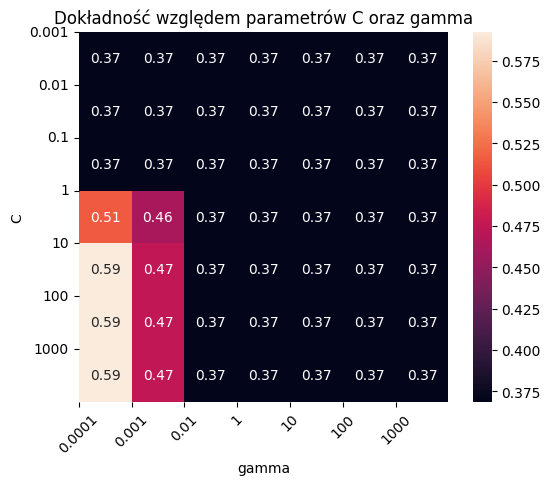

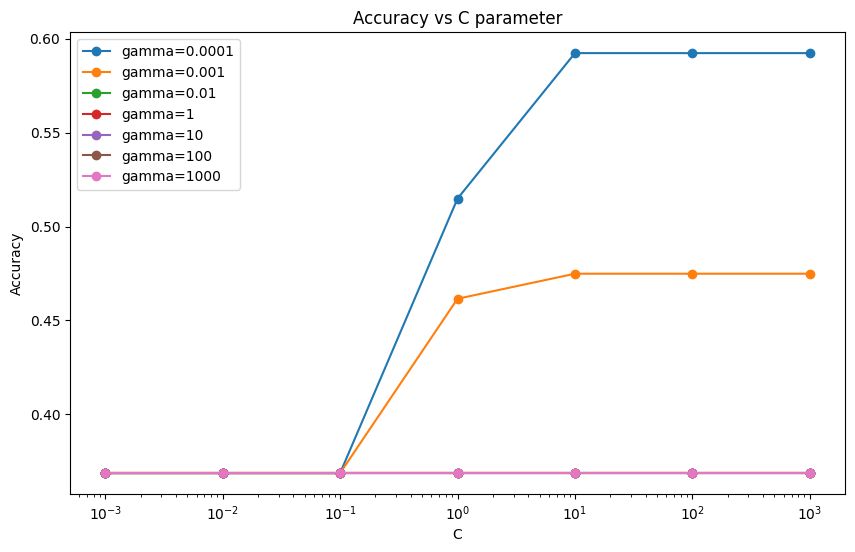

In [59]:
# define the parameter grid
data = df_normalized_NablonekPlaski_var
 # df_normalized_lung_cancer_var, df_normalized_NablonekPlaski_var, df_normalized_GLA_BRA_180_var
X_scaled = data.drop(['Type'],axis=1)
y = data.Type


param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':[0.0001, 0.001, 0.01, 1, 10, 100, 1000]}

svm = SVC(kernel='rbf')
grid_search = GridSearchCV(svm, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1)
grid_search.fit(X_scaled, y)
 
print(
    "Best parameters are {} \nScore : {}%".format(
        grid_search.best_params_, grid_search.best_score_*100)
)

scores = grid_search.cv_results_["mean_test_score"].reshape(
    len(param_grid['gamma']),
    len(param_grid['C']))
 
# Heatmap
sns.heatmap(scores, 
            # cmap = plt.cm.hot,
            annot= True, 
            cbar= True, 
            # vmin= 0, 
            # vmax=100,
            square=True)
 
plt.xlabel("gamma")
plt.ylabel("C")
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=0)
 
plt.title("Dokładność względem parametrów C oraz gamma")
plt.show()

plt.figure(figsize=(10, 6))
plt.title("Accuracy vs C parameter")
plt.xlabel("C")
plt.ylabel("Accuracy")
n = len(param_grid['C'])
for i in range(n):
    plt.plot(param_grid['C'], 
             scores[:,i], 
             'o-', label='gamma='+str(param_grid['gamma'][i]))

plt.legend()
plt.xscale('log')
plt.show()

## Decision Tree

In [60]:

def DT_classif_func(X_train, X_test, y_train, y_test):

    dtc = DecisionTreeClassifier()
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    sensitivity = recall_score(y_test, y_pred, average='weighted')
    f_measure = f1_score(y_test, y_pred, average='weighted')

    return accuracy, precision, sensitivity, f_measure
    


## Random Forest

In [61]:
def RandomForest_classif_func(X_train, X_test, y_train, y_test):

    rfc = RandomForestClassifier(n_estimators=128)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    sensitivity = recall_score(y_test, y_pred, average='weighted')
    f_measure = f1_score(y_test, y_pred, average='weighted')

    return accuracy, precision, sensitivity, f_measure


## kNN

In [62]:
def kNN_classif_func(X_train, X_test, y_train, y_test):

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    sensitivity = recall_score(y_test, y_pred, average='weighted')
    f_measure = f1_score(y_test, y_pred, average='weighted')

    return accuracy, precision, sensitivity, f_measure

# Filter gene selection approach

## Mutal Information

In [63]:
def MI_func(data, threshold_value):
    
    X = data.drop(['Type'],axis=1)
    y = data['Type']
    # threshold = int(np.ceil(len(X.columns) * threshold_value))

    high_score_features = []
    feature_scores = mutual_info_classif(X, y, random_state=0, n_neighbors=3, discrete_features='auto')
    for score, f_name in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold_value]:
        high_score_features.append(f_name)

    filtered_MI_df = data[['Type'] + high_score_features]

    return filtered_MI_df

## mRMR

In [64]:

def mRMR_func(data, threshold_value):
    
    X = data.drop(['Type'],axis=1)
    y = data['Type']
    # threshold = int(np.ceil(len(X.columns) * threshold_value))

    filtered_mRMR = mrmr_classif(X=X, y=y, K=threshold_value)

    filtered_mRMR_df = data[['Type'] + filtered_mRMR]

    return filtered_mRMR_df
    


## reliefF

In [65]:

def reliefF_func(data, threshold_value):
    
    X = data.drop(['Type'],axis=1)
    y = data['Type']
    # threshold = int(np.ceil(len(X.columns) * threshold_value))

    selector = relief(n_neighbors=10, n_features_to_keep=threshold_value)
    filtered_ReliefF_df = selector.fit_transform(X, y)
    selected_indices = selector.top_features_
    selected_features = X.columns[selected_indices].tolist()
    filtered_ReliefF_df = X[selected_features]

    return filtered_ReliefF_df



## Chi2

In [66]:

def chi_square_func(data, threshold_value):
    
    X = data.drop(['Type'],axis=1)
    y = data['Type']
    # threshold = int(np.ceil(len(X.columns) * threshold_value))
    
    scores, p_values = chi2(X, y)
    # top_k_indices = np.argsort(scores)[-threshold_value:]
    top_k_indices = np.argsort(p_values)[:threshold_value]
    selected_features = X.columns[top_k_indices]
    selected_features = selected_features.to_list()
    filtered_chi2_df = data[['Type'] + selected_features]
    
    return filtered_chi2_df


## ANOVA

In [67]:

def ANOVA_func(data, threshold_value):
    X = data.drop(['Type'],axis=1)
    y = data['Type']

    f_statistic, p_values = f_classif(X, y)
    top_k_indices = np.argsort(p_values)[:threshold_value]
    selected_features = X.columns[top_k_indices]
    selected_features = selected_features.to_list()
    filtered_ANOVA_df = data[['Type'] + selected_features]

    return filtered_ANOVA_df


## t-test

In [68]:

def t_test_func(data, threshold_value):
    
    X = data.drop(['Type'],axis=1)
    y = data['Type']

    class_labels = np.unique(y)
    p_vals = np.zeros((len(X.columns), len(class_labels) * (len(class_labels)-1) // 2))
    t_stats = np.zeros((len(X.columns), len(class_labels) * (len(class_labels)-1) // 2))
    k = 0
    for i in range(len(class_labels)):
        for j in range(i+1, len(class_labels)):
            x1 = X[y == class_labels[i]]
            x2 = X[y == class_labels[j]]
            t_stats[:, k], p_vals[:, k] = ttest_ind(x1, x2, axis=0)
            k += 1

    mean_t_stats = np.mean(t_stats, axis=1)
    feature_ranks = np.argsort(np.abs(mean_t_stats))[::-1]

    # n_features = X.shape[1]
    # n_selected_features = int(n_features * threshold_value)
    selected_features = X.columns[feature_ranks[:threshold_value]]
    
    selected_features = selected_features.to_list()
    filtered_ttest_df = data[['Type'] + selected_features]

    return filtered_ttest_df

## Filter results

In [ ]:
# results = []

# currentDateTime = datetime.now().strftime('%m_%d_%Y')

# approach = 'Filter approach'
# dataset_names = ['df_normalized_lung_cancer', 'df_normalized_SRBCT', 'df_normalized_NablonekPlaski', 'df_normalized_TOX_171', 'df_normalized_GLA_BRA_180', 'df_normalized_CLL_SUB_111']
# # dataset_lengths = []
# # func_names = ['Mutal Information', 'mRMR', 'Chi2', 't_test']
# func_names = ['Mutal Information', 'Chi2', 'ANOVA']
# classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
# k_values = [10, 20, 50, 100, 200, 500, 1000]
# # for d in [df_normalized_lung_cancer, df_normalized_SRBCT, df_normalized_NablonekPlaski, df_normalized_TOX_171, df_normalized_GLA_BRA_180]:
# for d, d_name in zip([df_normalized_lung_cancer, df_normalized_SRBCT, df_normalized_NablonekPlaski, df_normalized_TOX_171, df_normalized_GLA_BRA_180, df_normalized_CLL_SUB_111], dataset_names):
#     # dataset_lengths.append(len(d.columns))
#     columns_num = len(d.columns)
#     for k in k_values:
#         # for func, f_name in zip([MI_func, mRMR_func, chi_square_func, t_test_func], func_names):
#         for func, f_name in zip([MI_func, chi_square_func, ANOVA_func], func_names):
#             # for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
#             threshold_value = k
#             dataset = d
#             selected_features = func(dataset, threshold_value)
#             selected_features.to_csv('outputs/filter_df/filter_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(k) + '_' + str(currentDateTime), index=False)
#             for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
#                 accuracy, precision, sensitivity, f_measure = classif(selected_features)

#                 result_dict = {
#                     'Method': approach,
#                     'Dataset': d_name,
#                     'Feature Selection method': f_name,
#                     'Classification method': c_name,
#                     'No. genes': columns_num,
#                     'No. selected genes': k,
#                     'Accuracy': accuracy,
#                     'Precision': precision,
#                     'Sensitivity': sensitivity,
#                     'F-measure': f_measure
#                 }

#                 results.append(result_dict)

# results_df = pd.DataFrame(results)
# results_df.to_csv('outputs/results_filter_{currentDateTime}.csv', index=False) #dodać date do pliku 

In [251]:
# version with 3 datasets and weighted metrics 
# svc rbf default parameters 
# updated version - avoiding recomputing, data splitting, 

results = []

currentDateTime = datetime.now().strftime('%m_%d_%Y')

approach = 'Filter approach'
dataset_names = ['df_normalized_lung_cancer', 'df_normalized_NablonekPlaski', 'df_normalized_GLA_BRA_180']
func_names = ['Mutal Information', 'Chi2', 'ANOVA']
classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
k_values = [1000, 500, 200, 100, 50, 20, 10]

for d, d_name in zip([df_normalized_lung_cancer_var, df_normalized_NablonekPlaski_var, df_normalized_GLA_BRA_180_var], dataset_names):
    columns_num = len(d.columns)
    print(d_name)
    
    X = d.drop(['Type'],axis=1)
    y = d['Type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train_max = X_train.max()
    X_train_min = X_train.min()

    X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_train_normalized.insert(loc=0, column='Type', value=y)

    X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)
    
    prev_selected_features = None

    for k in k_values:
        print(k)

        for func, f_name in zip([MI_func, chi_square_func, ANOVA_func], func_names):
            print(f_name)

            threshold_value = k
            dataset = X_train_normalized

            if prev_selected_features is not None:
                dataset = prev_selected_features

            X_train_normalized_selected_features = func(dataset, threshold_value)
            prev_selected_features = X_train_normalized_selected_features
            
            # X_train_normalized_selected_features.to_csv('outputs/filter_df/filter_train_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(k) + '-' + str(currentDateTime) + '.csv', index=False)

            X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
            X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

            selected_features_list = X_train_normalized_selected_features.columns.to_list()
            X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test
            train_set = len(X_train_normalized_selected_features)
            test_set = len(X_test_normalized_selected)

            # concated train and test in order to use them in hybrid methods 
            X_train_all = X_train_normalized_selected_features.copy()
            X_train_all.insert(loc=0, column='Type', value=X_train_normalized_selected_features_y)
            # X_train_all = X_train_normalized_selected_features.insert(loc=0, column='Type', value=X_train_normalized_selected_features_y)
            X_train_all.insert(loc=1, column='Group', value='Train')

            X_test_all = X_test_normalized_selected.copy()
            X_test_all.insert(loc=0, column='Type', value=y_test)
            # X_test_all = X_test_normalized_selected.insert(loc=0, column='Type', value=y_test)
            X_test_all.insert(loc=1, column='Group', value='Test')

            X_all = pd.concat([X_train_all, X_test_all])
            X_all.to_csv('outputs/filter_df/filter_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(k) + 'genes-' + str(currentDateTime) + '.csv', index=False)

            for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
                print(c_name)
                accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)

                result_dict = {
                    'Method': approach,
                    'Dataset': d_name,
                    'Feature Selection method': f_name,
                    'Classification method': c_name,
                    'No. genes': columns_num,
                    'No. selected genes': k,
                    'Train set': train_set,
                    'Test set': test_set,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Sensitivity': sensitivity,
                    'F-measure': f_measure
                }

                results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('outputs/results_splitted-filter-weighted_metrics-' + str(currentDateTime) + '.csv', index=False) 

df_normalized_lung_cancer
1000
Mutal Information
Naive Bayes
SVM
kNN
Random Forest
Chi2
Naive Bayes
SVM
kNN
Random Forest
ANOVA
Naive Bayes
SVM
kNN
Random Forest
500
Mutal Information
Naive Bayes
SVM
kNN
Random Forest
Chi2
Naive Bayes
SVM
kNN
Random Forest
ANOVA
Naive Bayes
SVM
kNN
Random Forest
200
Mutal Information
Naive Bayes
SVM
kNN
Random Forest
Chi2
Naive Bayes
SVM
kNN
Random Forest
ANOVA
Naive Bayes
SVM
kNN
Random Forest
100
Mutal Information
Naive Bayes
SVM
kNN
Random Forest
Chi2
Naive Bayes
SVM
kNN
Random Forest
ANOVA
Naive Bayes
SVM
kNN
Random Forest
50
Mutal Information
Naive Bayes
SVM
kNN
Random Forest
Chi2
Naive Bayes
SVM
kNN
Random Forest
ANOVA
Naive Bayes
SVM
kNN
Random Forest
20
Mutal Information
Naive Bayes
SVM
kNN
Random Forest
Chi2
Naive Bayes
SVM
kNN
Random Forest
ANOVA
Naive Bayes
SVM
kNN
Random Forest
10
Mutal Information
Naive Bayes
SVM
kNN
Random Forest
Chi2
Naive Bayes
SVM
kNN
Random Forest
ANOVA
Naive Bayes
SVM
kNN
Random Forest
df_normalized_NablonekPlaski
10

In [62]:
# # updated version - avoiding recomputing, data splitting 

# results = []

# currentDateTime = datetime.now().strftime('%m_%d_%Y')

# approach = 'Filter approach'
# dataset_names = ['df_normalized_lung_cancer', 'df_normalized_SRBCT', 'df_normalized_NablonekPlaski', 'df_normalized_TOX_171', 'df_normalized_GLA_BRA_180', 'df_normalized_CLL_SUB_111']
# func_names = ['Mutal Information', 'Chi2', 'ANOVA']
# classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
# k_values = [1000, 500, 200, 100, 50, 20, 10]

# for d, d_name in zip([df_normalized_lung_cancer, df_normalized_SRBCT, df_normalized_NablonekPlaski, df_normalized_TOX_171, df_normalized_GLA_BRA_180, df_normalized_CLL_SUB_111], dataset_names):
#     columns_num = len(d.columns)
    
#     X = d.drop(['Type'],axis=1)
#     y = d['Type']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#     X_train_max = X_train.max()
#     X_train_min = X_train.min()

#     X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
#     X_train_normalized.insert(loc=0, column='Type', value=y)

#     X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)
    
#     prev_selected_features = None

#     for k in k_values:

#         for func, f_name in zip([MI_func, chi_square_func, ANOVA_func], func_names):

#             threshold_value = k
#             dataset = X_train_normalized

#             if prev_selected_features is not None:
#                 dataset = prev_selected_features

#             X_train_normalized_selected_features = func(dataset, threshold_value)
#             prev_selected_features = X_train_normalized_selected_features
            
#             # X_train_normalized_selected_features.to_csv('outputs/filter_df/filter_train_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(k) + '-' + str(currentDateTime) + '.csv', index=False)

#             X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
#             X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

#             selected_features_list = X_train_normalized_selected_features.columns.to_list()
#             X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test
#             train_set = len(X_train_normalized_selected_features)
#             test_set = len(X_test_normalized_selected)

#             # concated train and test in order to use them in hybrid methods 
#             X_train_all = X_train_normalized_selected_features.copy()
#             X_train_all.insert(loc=0, column='Type', value=X_train_normalized_selected_features_y)
#             # X_train_all = X_train_normalized_selected_features.insert(loc=0, column='Type', value=X_train_normalized_selected_features_y)
#             X_train_all.insert(loc=1, column='Group', value='Train')

#             X_test_all = X_test_normalized_selected.copy()
#             X_test_all.insert(loc=0, column='Type', value=y_test)
#             # X_test_all = X_test_normalized_selected.insert(loc=0, column='Type', value=y_test)
#             X_test_all.insert(loc=1, column='Group', value='Test')

#             X_all = pd.concat([X_train_all, X_test_all])
#             X_all.to_csv('outputs/filter_df/filter_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(k) + 'genes-' + str(currentDateTime) + '.csv', index=False)

#             for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
#                 accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)

#                 result_dict = {
#                     'Method': approach,
#                     'Dataset': d_name,
#                     'Feature Selection method': f_name,
#                     'Classification method': c_name,
#                     'No. genes': columns_num,
#                     'No. selected genes': k,
#                     'Train set': train_set,
#                     'Test set': test_set,
#                     'Accuracy': accuracy,
#                     'Precision': precision,
#                     'Sensitivity': sensitivity,
#                     'F-measure': f_measure
#                 }

#                 results.append(result_dict)

# results_df = pd.DataFrame(results)
# results_df.to_csv('outputs/results_splitted-filter-' + str(currentDateTime) + '.csv', index=False) 

# Wrapper gene selection approach 

## Sequential Forward Selection

In [ ]:
# def sequential_forward_selection_tool(data, threshold_value):
#     X = data.drop(['Type'],axis=1)
#     y = data['Type']
#     feature_names = X.columns.tolist()
    
#     clf = LogisticRegression()
#     sfs = SequentialFeatureSelector(clf, n_features_to_select=threshold_value, direction='forward', scoring='accuracy')
#     sfs.fit(X, y)
#     selected_features_SFS = sfs.get_support(indices=True)

#     selected_feature_names = [feature_names[feature_index] for feature_index in selected_features_SFS]
#     filtered_SFS_df = data[['Type'] + selected_feature_names]
    
#     return filtered_SFS_df

# selected_features_SFS = sequential_forward_selection_tool(df_normalized_lung_cancer, 3)

In [ ]:
# results = []

# approach = 'Wrapper approach'
# dataset_names = ['df_normalized_lung_cancer', 'df_normalized_SRBCT', 'df_normalized_NablonekPlaski', 'df_normalized_TOX_171', 'df_normalized_GLA_BRA_180', 'df_normalized_CLL_SUB_111']
# func_names = ['Sequential Forward Selection']
# classif_names = ['Naive Bayes', 'SVM', 'Decision Tree', 'kNN', 'Random Forest']
# k_values = [10, 20, 50, 100, 200, 500, 1000]
# for d, d_name in zip([df_normalized_lung_cancer, df_normalized_SRBCT, df_normalized_NablonekPlaski, df_normalized_TOX_171, df_normalized_GLA_BRA_180, df_normalized_CLL_SUB_111], dataset_names):
#     columns_num = len(d.columns)
#     for k in k_values:
#         for func, f_name in zip([sequential_forward_selection_tool], func_names):
#             for classif, c_name in zip([NB_classif_func, SVM_classif_func, DT_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
#                 threshold_value = k
#                 dataset = d
#                 selected_features = func(dataset, threshold_value)
#                 accuracy, precision, sensitivity, f_measure = classif(selected_features)

#                 result_dict = {
#                     'Method': approach,
#                     'Dataset': d_name,
#                     'Feature Selection method': f_name,
#                     'Classification method': c_name,
#                     'No. genes': columns_num,
#                     'No. selected genes': k,
#                     'Accuracy': accuracy,
#                     'Precision': precision,
#                     'Sensitivity': sensitivity,
#                     'F-measure': f_measure
#                 }

#                 results.append(result_dict)

# results_df = pd.DataFrame(results)
# results_df.to_csv('results/results-wrapper-sfs.csv', index=False)

## GA

In [69]:
def genetic_algorithm(data, iterations):

    X = data.drop(['Type'],axis=1)
    y = data['Type']
    column_names = X.columns.tolist()

    num_features = len(X.columns)
    # population_size = 100
    population_size = len(X)
    mutation_rate = 0.01
    generations = iterations

    def create_chromosome(num_features):
        chromosome = [random.randint(0, 1) for _ in range(num_features)]
        return chromosome

    def initialize_population(population_size, num_features):
        population = [create_chromosome(num_features) for _ in range(population_size)]
        return population

    def evaluate_fitness(chromosome, X, y):
        selected_features = [i for i, gene in enumerate(chromosome) if gene == 1]
        if len(selected_features) == 0:
            return 0.0 

        X_selected = X.iloc[:, selected_features]
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
        
        if len(np.unique(y_train)) < 2:
            return 0.0 
        
        # classifier = SVC(C=100, kernel='rbf')
        classifier = KNeighborsClassifier(n_neighbors=5)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        fitness = accuracy_score(y_test, y_pred)
        return fitness
    
    # def parallel_evaluate_population(population):
    #     pool = multiprocessing.Pool(processes=multiprocessing.cpu_count() // 2)
    #     fitness_scores = pool.map(lambda chromosome: evaluate_fitness(chromosome, X, y), population)
    #     pool.close()
    #     pool.join()
    #     return fitness_scores

    def evaluate_population(population):
        fitness_scores = [evaluate_fitness(chromosome, X, y) for chromosome in population]
        return fitness_scores

    def selection(population, fitness_scores):
        sorted_population = [x for _, x in sorted(zip(fitness_scores, population), reverse=True)]
        selected_parents = sorted_population[:len(population) // 2]
        return selected_parents

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        child = parent1[:crossover_point] + parent2[crossover_point:]
        return child

    def mutation(chromosome, mutation_rate):
        mutated_chromosome = chromosome.copy()
        for i in range(len(chromosome)):
            if random.random() < mutation_rate:
                mutated_chromosome[i] = 1 - mutated_chromosome[i]
        return mutated_chromosome

    def reproduce(selected_parents, population_size, mutation_rate):
        new_population = []
        while len(new_population) < population_size:
            parent1 = random.choice(selected_parents)
            parent2 = random.choice(selected_parents)
            child = crossover(parent1, parent2)
            child = mutation(child, mutation_rate)
            new_population.append(child)
        return new_population

    population = initialize_population(population_size, num_features)

    for _ in range(generations):
        # fitness_scores = evaluate_population(population)
        fitness_scores = evaluate_population(population)
        selected_parents = selection(population, fitness_scores)
        population = reproduce(selected_parents, population_size, mutation_rate)

    best_chromosome = max(population, key=lambda chromosome: evaluate_fitness(chromosome, X, y))
    selected_features = [column_names[i] for i, gene in enumerate(best_chromosome) if gene == 1]
    filtered_GA_df = data[['Type'] + selected_features]

    return filtered_GA_df

In [ ]:
# GA with min-max normalizaation after data splitting 

# import random
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score

# def genetic_algorithm(data, iterations=200):

#     X = data.drop(['Type'], axis=1)
#     y = data['Type']
#     column_names = X.columns.tolist()

#     num_features = len(X.columns)
#     population_size = len(X)
#     mutation_rate = 0.01
#     generations = iterations

#     # Split the data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#     def create_chromosome(num_features):
#         chromosome = [random.randint(0, 1) for _ in range(num_features)]
#         return chromosome

#     def evaluate_fitness(chromosome, X, y):
#         selected_features = [i for i, gene in enumerate(chromosome) if gene == 1]
#         if len(selected_features) == 0:
#             return 0.0

#         X_selected = X.iloc[:, selected_features]

#         # Min-Max scaling (normalization) on the training set
#         min_vals = X_selected.min()
#         max_vals = X_selected.max()
#         X_selected = (X_selected - min_vals) / (max_vals - min_vals)

#         classifier = SVC()
#         classifier.fit(X_selected, y_train)
#         y_pred = classifier.predict(X_test)

#         fitness = accuracy_score(y_test, y_pred)
#         return fitness

#     def selection(population, fitness_scores):
#         sorted_population = [x for _, x in sorted(zip(fitness_scores, population), reverse=True)]
#         selected_parents = sorted_population[:len(population) // 2]
#         return selected_parents

#     def crossover(parent1, parent2):
#         crossover_point = random.randint(1, len(parent1) - 1)
#         child = parent1[:crossover_point] + parent2[crossover_point:]
#         return child

#     def mutation(chromosome, mutation_rate):
#         mutated_chromosome = chromosome.copy()
#         for i in range(len(chromosome)):
#             if random.random() < mutation_rate:
#                 mutated_chromosome[i] = 1 - mutated_chromosome[i]
#         return mutated_chromosome

#     def reproduce(selected_parents, population_size, mutation_rate):
#         new_population = []
#         while len(new_population) < population_size:
#             parent1 = random.choice(selected_parents)
#             parent2 = random.choice(selected_parents)
#             child = crossover(parent1, parent2)
#             child = mutation(child, mutation_rate)
#             new_population.append(child)
#         return new_population

#     population = initialize_population(population_size, num_features)

#     for _ in range(generations):
#         fitness_scores = evaluate_population(population)
#         selected_parents = selection(population, fitness_scores)
#         population = reproduce(selected_parents, population_size, mutation_rate)

#     best_chromosome = max(population, key=lambda chromosome: evaluate_fitness(chromosome, X, y))
#     selected_features = [column_names[i] for i, gene in enumerate(best_chromosome) if gene == 1]
#     filtered_GA_df = data[['Type'] + selected_features]

#     return filtered_GA_df

# # Example usage:
# # filtered_data = genetic_algorithm(your_data, iterations=200)


In [70]:
# updated GA version - the final criterion to observing convergence of fitness values for subsequent generations instead of given number of generations

def genetic_algorithm_ceonsecutive_gen(data):

    X = data.drop(['Type'],axis=1)
    y = data['Type']
    column_names = X.columns.tolist()

    num_features = len(X.columns)
    # population_size = 100
    population_size = len(X)
    mutation_rate = 0.01
    # generations = 10
    max_consecutive_generations = 50
    consecutive_generations = 0

    def create_chromosome(num_features):
        chromosome = [random.randint(0, 1) for _ in range(num_features)]
        return chromosome

    def initialize_population(population_size, num_features):
        population = [create_chromosome(num_features) for _ in range(population_size)]
        return population

    def evaluate_fitness(chromosome, X, y):
        selected_features = [i for i, gene in enumerate(chromosome) if gene == 1]
        if len(selected_features) == 0:
            return 0.0 

        X_selected = X.iloc[:, selected_features]
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
        
        if len(np.unique(y_train)) < 2:
            return 0.0 
        
        classifier = SVC()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        fitness = accuracy_score(y_test, y_pred)
        return fitness

    def evaluate_population(population):
        fitness_scores = [evaluate_fitness(chromosome, X, y) for chromosome in population]
        return fitness_scores

    def selection(population, fitness_scores):
        sorted_population = [x for _, x in sorted(zip(fitness_scores, population), reverse=True)]
        selected_parents = sorted_population[:len(population) // 2]
        return selected_parents

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        child = parent1[:crossover_point] + parent2[crossover_point:]
        return child

    def mutation(chromosome, mutation_rate):
        mutated_chromosome = chromosome.copy()
        for i in range(len(chromosome)):
            if random.random() < mutation_rate:
                mutated_chromosome[i] = 1 - mutated_chromosome[i]
        return mutated_chromosome

    def reproduce(selected_parents, population_size, mutation_rate):
        new_population = []
        while len(new_population) < population_size:
            parent1 = random.choice(selected_parents)
            parent2 = random.choice(selected_parents)
            child = crossover(parent1, parent2)
            child = mutation(child, mutation_rate)
            new_population.append(child)
        return new_population

    population = initialize_population(population_size, num_features)
    best_fitness = 0

    while consecutive_generations < max_consecutive_generations:
        fitness_scores = evaluate_population(population)
        selected_parents = selection(population, fitness_scores)
        population = reproduce(selected_parents, population_size, mutation_rate)

        max_fitness = max(fitness_scores)

        if max_fitness> best_fitness:
            best_fitness = max_fitness
            consecutive_generations = 0
        else:
            consecutive_generations += 1

    best_chromosome = max(population, key=lambda chromosome: evaluate_fitness(chromosome, X, y))
    selected_features = [column_names[i] for i, gene in enumerate(best_chromosome) if gene == 1]
    filtered_GA_df = data[['Type'] + selected_features]

    return filtered_GA_df

## ABC

In [71]:
def artificial_bee_colony(data, bees, iterations):
    X = data.drop(['Type'], axis=1)
    y = data['Type']

    num_employed_bees = bees
    num_onlooker_bees = bees
    max_iterations = iterations
    abandonment_limit = 30
    abandonment_counters = [0] * num_employed_bees

    num_features = X.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    def evaluate_fitness(selected_features, X_train, X_test, y_train, y_test):
        selected_indices = np.where(selected_features)[0]
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]

        # classifier = SVC(C=100, kernel='rbf')
        classifier = KNeighborsClassifier(n_neighbors=5)
        classifier.fit(X_train_selected, y_train)
        accuracy = classifier.score(X_test_selected, y_test)
        return accuracy

    def initialize_population(num_features):
        population = np.zeros((num_employed_bees, num_features), dtype=bool)
        for i in range(num_employed_bees):
            num_selected_features = np.random.randint(1, num_features)
            selected_features = np.random.choice(num_features, size=num_selected_features, replace=False)
            population[i, selected_features] = True
        return population

    def employed_bee_phase(population, fitness_values, X_train, X_test, y_train, y_test, abandonment_counters):
        for i in range(num_employed_bees):
            selected_features = population[i]
            num_features = len(selected_features)

            valid_neighbors = list(range(num_employed_bees))
            valid_neighbors.remove(i)
            k = np.random.choice(valid_neighbors)

            # k = np.random.randint(0, num_employed_bees)
            # while k == i:
            #     k = np.random.randint(0, num_employed_bees)

            neighbor = population[k]
            j = np.random.randint(0, num_features)
            new_solution = np.copy(selected_features)
            new_solution[j] = neighbor[j]
            new_fitness = evaluate_fitness(new_solution, X_train, X_test, y_train, y_test)
            if new_fitness > fitness_values[i]:
                population[i] = new_solution
                fitness_values[i] = new_fitness
                abandonment_counters[i] = 0
            else: 
                abandonment_counters[i] += 1

    def onlooker_bee_phase(population, fitness_values, X_train, X_test, y_train, y_test, abandonment_counters):
        total_fitness = np.sum(fitness_values)
        probabilities = fitness_values / total_fitness
        selected_indices = np.random.choice(num_employed_bees, size=num_onlooker_bees, replace=True,
                                            p=probabilities)
        for i in selected_indices:
            selected_features = population[i]
            num_features = len(selected_features)

            valid_neighbors = list(range(num_employed_bees))
            valid_neighbors.remove(i)
            k = np.random.choice(valid_neighbors)

            # k = np.random.randint(0, num_employed_bees)
            # while k == i:
            #     k = np.random.randint(0, num_employed_bees)

            neighbor = population[k]
            j = np.random.randint(0, num_features)
            new_solution = np.copy(selected_features)
            new_solution[j] = neighbor[j]
            new_fitness = evaluate_fitness(new_solution, X_train, X_test, y_train, y_test)
            if new_fitness > fitness_values[i]:
                population[i] = new_solution
                fitness_values[i] = new_fitness
                abandonment_counters[i] = 0
            else: 
                abandonment_counters[i] += 1

    def scout_bee_phase(population, fitness_values, num_features, abandonment_counters, abandonment_limit):
        max_fitness_index = np.argmax(fitness_values)
        max_fitness = fitness_values[max_fitness_index]
        if max_fitness == 0:
            abandonment_counters[max_fitness_index] += 1

            if abandonment_counters[max_fitness_index] >= abandonment_limit:
                abandonment_counters[max_fitness_index] = 0
                population[max_fitness_index] = np.random.choice([True, False], size=num_features)
                fitness_values[max_fitness_index] = evaluate_fitness(population[max_fitness_index], X_train, X_test, y_train, y_test)

    population = initialize_population(num_features)
    fitness_values = np.zeros(num_employed_bees)

    for _ in range(max_iterations):
        employed_bee_phase(population, fitness_values, X_train, X_test, y_train, y_test, abandonment_counters)
        onlooker_bee_phase(population, fitness_values, X_train, X_test, y_train, y_test, abandonment_counters)
        scout_bee_phase(population, fitness_values, num_features, abandonment_counters, abandonment_limit)

    best_solution_index = np.argmax(fitness_values)
    best_solution = population[best_solution_index]
    selected_features = np.where(best_solution)[0]

    selected_column_names = X.columns[selected_features].tolist()

    filtered_ABC_df = data[['Type'] + selected_column_names]

    return filtered_ABC_df

## PSO

In [72]:
def particle_swarm_optimization(data, particles, iterations):

    X = data.drop(['Type'], axis=1)
    y = data['Type']

    num_particles = particles
    max_iterations = iterations
    
    num_features = X.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    def initialize_particles(num_particles, num_features):
        particles = []
        for _ in range(num_particles):
            position = np.random.choice([0, 1], size=num_features)
            velocity = np.zeros_like(position)
            best_position = position.copy()
            best_fitness = float('-inf')
            particle = (position, velocity, best_position, best_fitness)
            particles.append(particle)
        return particles

    def fitness_function(feature_subset, X_train, y_train, X_test, y_test):
        selected_features = [feature for feature, gene in zip(X_train.columns, feature_subset) if gene == 1]
        
        if not selected_features:
            return 0.0  # Return a fitness of 0 if no features are selected
    
        selected_feature_indices = [X_train.columns.get_loc(feature) for feature in selected_features]
        X_train_selected = X_train.iloc[:, selected_feature_indices]
        X_test_selected = X_test.iloc[:, selected_feature_indices]
        
        # model = SVC(C=100, kernel='rbf')
        model = KNeighborsClassifier(n_neighbors=5)
        model.fit(X_train_selected, y_train)
        accuracy = model.score(X_test_selected, y_test)

        return accuracy

    def update_particle(particle, best_global_position, inertia_weight=0.7, cognitive_weight=2, social_weight=2):
        position, velocity, best_position, _ = particle

        r1 = np.random.rand(len(position))
        r2 = np.random.rand(len(position))

        new_velocity = (inertia_weight * velocity +
                        cognitive_weight * r1 * (best_position - position) +
                        social_weight * r2 * (best_global_position - position))

        new_position = np.where(new_velocity > 0, 1, 0)

        return new_position, new_velocity

    def search(num_particles, num_features, max_iterations, X_train, y_train, X_test, y_test):
        particles = initialize_particles(num_particles, num_features)
        best_global_position = None
        best_global_fitness = float('-inf')

        for _ in range(max_iterations):
            for i, particle in enumerate(particles):
                position, _, best_position, _ = particle
                fitness = fitness_function(position, X_train, y_train, X_test, y_test)

                if fitness > np.max(best_position):
                    particles[i] = (position, _, position, fitness)

                if fitness > best_global_fitness:
                    best_global_position = position
                    best_global_fitness = fitness

                new_position, new_velocity = update_particle(particle, best_global_position)
                particles[i] = (new_position, new_velocity, best_position, fitness)

        return best_global_position, best_global_fitness
    
    best_global_position, best_global_fitness = search(num_particles, num_features, max_iterations, X_train, y_train, X_test, y_test)

    selected_features = [feature for feature, gene in zip(X.columns, best_global_position) if gene == 1]
    selected_column_names = selected_features

    filtered_PSO_df = data[['Type'] + selected_column_names]

    return filtered_PSO_df

## Wrapper results

### GA results

In [224]:
# updated version - data splitting  

results = []

currentDateTime = datetime.now().strftime('%m_%d_%Y')

approach = 'Wrapper approach'
dataset_names = ['df_normalized_lung_cancer', 'df_normalized_SRBCT', 'df_normalized_NablonekPlaski', 'df_normalized_TOX_171', 'df_normalized_GLA_BRA_180', 'df_normalized_CLL_SUB_111']
func_names = ['Genetic Algorithm']
classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
iters = [50, 100, 200, 500, 1000, 2000]

for d, d_name in zip([df_normalized_lung_cancer, df_normalized_SRBCT, df_normalized_NablonekPlaski, df_normalized_TOX_171, df_normalized_GLA_BRA_180, df_normalized_CLL_SUB_111], dataset_names):

    X = d.drop(['Type'],axis=1)
    y = d['Type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train_max = X_train.max()
    X_train_min = X_train.min()

    X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_train_normalized.insert(loc=0, column='Type', value=y)

    X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)

    print(d_name)
    columns_num = len(d.columns)
    for it in iters:
        print(it)
        for func, f_name in zip([genetic_algorithm], func_names):
            print(f_name)

            dataset = X_train_normalized

            X_train_normalized_selected_features = func(dataset, it)
            k_selected = len(X_train_normalized_selected_features.columns)
            print('No. selected genes: ' + str(k_selected))
            X_train_normalized_selected_features.to_csv('outputs/wrapper_df/wrapper_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(it) + 'iter-' + str(currentDateTime) + '.csv', index=False)

            X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
            X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

            selected_features_list = X_train_normalized_selected_features.columns.to_list()
            X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test


            for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
                print(c_name)
                accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)
                print('Accuracy: ' + str(accuracy))

                result_dict = {
                    'Method': approach,
                    'Dataset': d_name,
                    'Feature Selection method': f_name,
                    'Classification method': c_name,
                    'No. genes': columns_num,
                    'No. selected genes': k_selected,
                    'No. iterations': it,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Sensitivity': sensitivity,
                    'F-measure': f_measure
                }

                results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('outputs/results_splitted_wrapper_GA-' + str(currentDateTime) + '.csv', index=False)

df_normalized_lung_cancer
2
Genetic Algorithm
No. selected genes: 6308
Naive Bayes
Accuracy: 0.8536585365853658
SVM
Accuracy: 0.975609756097561
kNN
Accuracy: 0.9024390243902439
Random Forest
Accuracy: 0.8780487804878049
df_normalized_SRBCT
2
Genetic Algorithm
No. selected genes: 1102
Naive Bayes
Accuracy: 0.9411764705882353
SVM
Accuracy: 1.0
kNN
Accuracy: 0.9411764705882353
Random Forest
Accuracy: 1.0
df_normalized_NablonekPlaski
2
Genetic Algorithm
No. selected genes: 11276
Naive Bayes
Accuracy: 0.375
SVM
Accuracy: 0.625
kNN
Accuracy: 0.6875
Random Forest
Accuracy: 0.5
df_normalized_TOX_171
2
Genetic Algorithm
No. selected genes: 2954
Naive Bayes
Accuracy: 0.8285714285714286
SVM
Accuracy: 0.9428571428571428
kNN
Accuracy: 0.8
Random Forest
Accuracy: 0.7428571428571429
df_normalized_GLA_BRA_180
2
Genetic Algorithm
No. selected genes: 24585
Naive Bayes
Accuracy: 0.7777777777777778
SVM
Accuracy: 0.75
kNN
Accuracy: 0.75
Random Forest
Accuracy: 0.75
df_normalized_CLL_SUB_111
2
Genetic Algor

### ABC and PSO 

In [ ]:
# updated version - data splitting  

results = []

currentDateTime = datetime.now().strftime('%m_%d_%Y')

approach = 'Wrapper approach'
dataset_names = ['df_normalized_lung_cancer', 'df_normalized_SRBCT', 'df_normalized_NablonekPlaski', 'df_normalized_TOX_171', 'df_normalized_GLA_BRA_180', 'df_normalized_CLL_SUB_111']
func_names = ['Artificial Bee Colony', 'Particle Swarm Optimization']
classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
iters = [100, 200, 500, 1000, 2000]
particles = [10, 20, 50, 100, 200, 500, 1000, 2000]

for d, d_name in zip([df_normalized_lung_cancer, df_normalized_SRBCT, df_normalized_NablonekPlaski, df_normalized_TOX_171, df_normalized_GLA_BRA_180, df_normalized_CLL_SUB_111], dataset_names):

    X = d.drop(['Type'],axis=1)
    y = d['Type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train_max = X_train.max()
    X_train_min = X_train.min()

    X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_train_normalized.insert(loc=0, column='Type', value=y)

    X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)

    print(d_name)
    columns_num = len(d.columns)

    for p in particles:
        print(p)
        for it in iters:
            print(it)
            for func, f_name in zip([artificial_bee_colony, particle_swarm_optimization], func_names):
                print(f_name)

                dataset = X_train_normalized

                X_train_normalized_selected_features = func(dataset, p, it)
                k_selected = len(X_train_normalized_selected_features.columns)
                print('No. selected genes: ' + str(k_selected))
                X_train_normalized_selected_features.to_csv('outputs/wrapper_df/wrapper_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(it) + 'iter-' + str(pset) + 'pset_' + str(currentDateTime) + '.csv', index=False)
                
                X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
                X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

                selected_features_list = X_train_normalized_selected_features.columns.to_list()
                X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test
                

                for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
                    print(c_name)
                    accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)
                    print('Accuracy: ' + str(accuracy))

                    result_dict = {
                        'Method': approach,
                        'Dataset': d_name,
                        'Feature Selection method': f_name,
                        'Classification method': c_name,
                        'No. genes': columns_num,
                        'No. selected genes': k_selected,
                        'Bees or particles': p, 
                        'Iterations': it, 
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Sensitivity': sensitivity,
                        'F-measure': f_measure
                    }

                    results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('outputs/results_splitted_wrapper_ABC_PSO-' + str(currentDateTime) + '.csv', index=False)

# Embedded gene selection approach 

## LASSO

In [73]:
from sklearn.linear_model import Lasso

def lasso_func(data):

    X = data.drop(['Type'], axis=1)
    y = data['Type']

    lasso = Lasso(alpha=0.1)

    lasso.fit(X, y)

    selected_features = lasso.coef_ != 0

    selected_feature_names = X.columns[selected_features]

    selected_features = selected_feature_names.to_list()

    filtered_LASSO_df = data[['Type'] + selected_features]

    return filtered_LASSO_df

## Ridge

In [74]:
def ridge_regression_func(data, threshold_value, a=0.1):
    
    X = data.drop(['Type'], axis=1)
    y = data['Type']

    ridge = Ridge(alpha=a, fit_intercept=True, tol = 0.001)

    ridge.fit(X, y)

    # selected_features = ridge.coef_ > 0.005
    selected_features = abs(ridge.coef_).argsort()[::1][:threshold_value]

    selected_feature_names = X.columns[selected_features]

    selected_features = selected_feature_names.to_list()

    filtered_Ridge_df = data[['Type'] + selected_features]

    return filtered_Ridge_df


## SVM-RFE

In [75]:
def SVM_RFE_func(data, threshold_value): 
    X = data.drop(['Type'], axis=1)
    y = data['Type']
    
    svm = SVC(kernel='linear')
    # svm = SVC(C=1000, kernel='rbf', gamma=0.0001)
    rfe = RFE(estimator=svm, n_features_to_select=threshold_value)

    rfe.fit(X, y)
    selected_features = rfe.get_support()

    selected_feature_names = X.columns[selected_features]

    selected_features = selected_feature_names.to_list()

    filtered_SVM_RFE_df = data[['Type'] + selected_features]

    return filtered_SVM_RFE_df


## Random Forest

In [76]:
def Random_Forests_func(data, threshold_value, trees=100): 
    X = data.drop(['Type'], axis=1)
    y = data['Type']

    rf = RandomForestClassifier(n_estimators=trees, random_state=42) # do for many number of trees [10, 20, 50, 100, 200, 500, 1000, 2000]
    rf.fit(X, y)

    feature_importances = rf.feature_importances_

    feature_importances_sorted = np.argsort(feature_importances)[::1]

    selected_features = feature_importances_sorted[:threshold_value]

    selected_feature_names = X.columns[selected_features]

    selected_features = selected_feature_names.to_list()

    filtered_Random_Forests_df = data[['Type'] + selected_features]

    return filtered_Random_Forests_df

## XGBoost

In [117]:
def xgb_func(data, threshold_value: int, trees: int, tree_depth: int, gamma_m: float):

    # type_mapping = {1: 0, 
    #                 2: 1, 
    #                 3: 2, 
    #                 4: 3, 
    #                 5: 4, 
    #                 6: 5}
    
    # def map_type(x):
    #     if x in type_mapping:
    #         return type_mapping[x]
    #     else: 
    #         return x

    # # data['Type'] = data['Type'].astype(int)
    # data['Type'] = data['Type'].map(map_type)

    X = data.drop(['Type'], axis=1)
    y = data['Type']

    num_class_m = len(y.unique())

    xgb_model = xgb.XGBClassifier(n_estimators=trees, 
                                max_depth=tree_depth, 
                                objective='multi:softmax', 
                                num_class=num_class_m,  
                                learning_rate=0.1,
                                gamma=gamma_m, 
                                reg_lambda=10,
                                random_state=42, 
                                subsample=0.9,
                                colsample_bytree=0.5)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    xgb_model.fit(X_train,
                y_train, 
                verbose=1,
                early_stopping_rounds=100, 
                eval_metric=['merror'], #TODO: create f1_score func to calculate eval_metric 
                eval_set=[(X_test, y_test)])

    xgb_feature_importances = xgb_model.feature_importances_
    xgb_feature_importances_sorted = np.argsort(xgb_feature_importances)[::-1]

    xgb_selected_features = xgb_feature_importances_sorted[:threshold_value]

    xgb_selected_feature_names = X.columns[xgb_selected_features]
    xgb_selected_features = xgb_selected_feature_names.to_list()
    filtered_XGB_df = data[['Type'] + xgb_selected_features]

    # reverse_type_mapping = {v: k for k, v in type_mapping.items()}
    # filtered_XGB_df['Type'] = filtered_XGB_df['Type'].map(reverse_type_mapping)
    
    return filtered_XGB_df

## Embedded results

### XGBoost 

In [116]:
df_normalized_lung_cancer_var.Type.unique()

array([1, 2, 3, 4], dtype=int64)

In [118]:
results = []

currentDateTime = datetime.now().strftime('%m_%d_%Y')

approach = 'Embedded approach'
# dataset_names = ['df_normalized_lung_cancer', 'df_normalized_NablonekPlaski', 'df_normalized_GLA_BRA_180']
dataset_names = ['df_normalized_lung_cancer']
func_names = ['XGBoost']
classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
# k_values = [10, 20, 50, 100, 200, 500, 1000]
k_values = [10, 100, 1000]
# trees_m = [10, 20, 50, 100, 200, 500, 1000, 2000]
trees_m = [10, 100, 1000]
tree_depth_m = [3, 4, 8, 16, 32]
gamma_m = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]

# for d, d_name in zip([df_normalized_lung_cancer_var, df_normalized_NablonekPlaski_var, df_normalized_GLA_BRA_180_var], dataset_names):
for d, d_name in zip([df_normalized_lung_cancer_var], dataset_names):

    # print(df_normalized_lung_cancer_var.Type.unique())
    
    X = d.drop(['Type'],axis=1)
    # y = d['Type']

    print(d.Type.unique())

    type_mapping = {1: 0, 
                    2: 1, 
                    3: 2, 
                    4: 3, 
                    5: 4, 
                    6: 5}
    
    def map_type(x):
        if x in type_mapping:
            return type_mapping[x]
        else: 
            return x

    # data['Type'] = data['Type'].astype(int)
    d['Type'] = d['Type'].map(map_type)
    y = d['Type']

    print(d.Type.unique())

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train_max = X_train.max()
    X_train_min = X_train.min()

    X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_train_normalized.insert(loc=0, column='Type', value=y)

    # print(X_train_normalized.Type.unique())

    X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)

    print(d_name)
    columns_num = len(d.columns)

    for g in gamma_m:
        print(g)
        for td in tree_depth_m:
            print(td)
            for t in trees_m:
                print(t)
                for k in k_values:
                    threshold_value = k
                    for func, f_name in zip([xgb_func], func_names):
                        print(f_name)

                        dataset = X_train_normalized

                        print(dataset.Type.unique())

                        X_train_normalized_selected_features = func(dataset, k, t, td, g)

                        X_train_normalized_selected_features.to_csv('outputs/embedded_df/embedded_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(t) + 'trees-' + str(td) + 'tree_depth-' + str(k) + 'features_' + str(currentDateTime) + '.csv', index=False)
                        
                        X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
                        X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

                        selected_features_list = X_train_normalized_selected_features.columns.to_list()
                        X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test

                        for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
                            print(c_name)
                            accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)
                            print('Accuracy: ' + str(accuracy))

                            result_dict = {
                                'Method': approach,
                                'Dataset': d_name,
                                'Feature Selection method': f_name,
                                'Classification method': c_name,
                                'No. genes': columns_num,
                                'No. selected genes': k,
                                'Trees num': trees_m,
                                'Tree depth':tree_depth_m, 
                                'Gamma': gamma_m,  
                                'Accuracy': accuracy,
                                'Precision': precision,
                                'Sensitivity': sensitivity,
                                'F-measure': f_measure
                            }

                            results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('outputs/results_splitted_embedded_XGBoost-weighted_metrics-' + str(currentDateTime) + '.csv', index=False)

[1 2 3 4]
[0 1 2 3]
df_normalized_lung_cancer
0.01
3
10
XGBoost
[2 0 3 1]
[0]	validation_0-merror:0.15625
[1]	validation_0-merror:0.15625
[2]	validation_0-merror:0.12500
[3]	validation_0-merror:0.12500
[4]	validation_0-merror:0.12500
[5]	validation_0-merror:0.12500
[6]	validation_0-merror:0.12500
[7]	validation_0-merror:0.12500
[8]	validation_0-merror:0.12500
[9]	validation_0-merror:0.12500
Naive Bayes
Accuracy: 0.8
SVM
Accuracy: 0.85
kNN
Accuracy: 0.925
Random Forest
Accuracy: 0.925
XGBoost
[2 0 3 1]
[0]	validation_0-merror:0.15625
[1]	validation_0-merror:0.15625
[2]	validation_0-merror:0.12500
[3]	validation_0-merror:0.12500
[4]	validation_0-merror:0.12500
[5]	validation_0-merror:0.12500
[6]	validation_0-merror:0.12500
[7]	validation_0-merror:0.12500
[8]	validation_0-merror:0.12500
[9]	validation_0-merror:0.12500
Naive Bayes
Accuracy: 0.925
SVM
Accuracy: 0.925
kNN
Accuracy: 0.925
Random Forest
Accuracy: 0.95
XGBoost
[2 0 3 1]
[0]	validation_0-merror:0.15625
[1]	validation_0-merror:0.

### Ridge

In [261]:
# version with 3 datasets and weighted metrics 
# svc rbf default parameters 
# updated version - data splitting  

results = []

currentDateTime = datetime.now().strftime('%m_%d_%Y')

approach = 'Embedded approach'
dataset_names = ['df_normalized_lung_cancer', 'df_normalized_NablonekPlaski', 'df_normalized_GLA_BRA_180']
func_names = ['Ridge regression']
classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
alpha_a = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]
k_values = [10, 20, 50, 100, 200, 500, 1000]
for d, d_name in zip([df_normalized_lung_cancer, df_normalized_NablonekPlaski, df_normalized_GLA_BRA_180], dataset_names):
    
    X = d.drop(['Type'],axis=1)
    y = d['Type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train_max = X_train.max()
    X_train_min = X_train.min()

    X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_train_normalized.insert(loc=0, column='Type', value=y)

    X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)
    
    print(d_name)
    columns_num = len(d.columns)

    for a in alpha_a:
        print(a)
        for k in k_values:
            threshold_value = k
            for func, f_name in zip([ridge_regression_func], func_names):
                print(f_name)

                dataset = X_train_normalized

                X_train_normalized_selected_features = func(dataset, k, a)

                X_train_normalized_selected_features.to_csv('outputs/embedded_df/embedded_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(a) + 'alpha-' + str(k) + '_' + str(currentDateTime) + '.csv', index=False)
                
                X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
                X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

                selected_features_list = X_train_normalized_selected_features.columns.to_list()
                X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test

                for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
                    print(c_name)
                    accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)
                    print('Accuracy: ' + str(accuracy))

                    result_dict = {
                        'Method': approach,
                        'Dataset': d_name,
                        'Feature Selection method': f_name,
                        'Classification method': c_name,
                        'No. genes': columns_num,
                        'No. selected genes': k,
                        'Lambda': a, 
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Sensitivity': sensitivity,
                        'F-measure': f_measure
                    }

                    results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('outputs/results_splitted_embedded_Ridge-weighted_metrics-' + str(currentDateTime) + '.csv', index=False)

df_normalized_lung_cancer
1e-15
Ridge regression
Naive Bayes
Accuracy: 0.575
SVM
Accuracy: 0.7
kNN
Accuracy: 0.7
Random Forest
Accuracy: 0.75
Ridge regression
Naive Bayes
Accuracy: 0.55
SVM
Accuracy: 0.7
kNN
Accuracy: 0.675
Random Forest
Accuracy: 0.675
Ridge regression
Naive Bayes
Accuracy: 0.625
SVM
Accuracy: 0.7
kNN
Accuracy: 0.7
Random Forest
Accuracy: 0.7
Ridge regression
Naive Bayes
Accuracy: 0.75
SVM
Accuracy: 0.8
kNN
Accuracy: 0.8
Random Forest
Accuracy: 0.825
Ridge regression
Naive Bayes
Accuracy: 0.725
SVM
Accuracy: 0.875
kNN
Accuracy: 0.75
Random Forest
Accuracy: 0.875
Ridge regression
Naive Bayes
Accuracy: 0.75
SVM
Accuracy: 0.9
kNN
Accuracy: 0.8
Random Forest
Accuracy: 0.8
Ridge regression
Naive Bayes
Accuracy: 0.75
SVM
Accuracy: 0.9
kNN
Accuracy: 0.825
Random Forest
Accuracy: 0.8
1e-10
Ridge regression
Naive Bayes
Accuracy: 0.575
SVM
Accuracy: 0.7
kNN
Accuracy: 0.7
Random Forest
Accuracy: 0.75
Ridge regression
Naive Bayes
Accuracy: 0.55
SVM
Accuracy: 0.7
kNN
Accuracy: 0.6

In [316]:
# updated version - data splitting  

results = []

currentDateTime = datetime.now().strftime('%m_%d_%Y')

approach = 'Embedded approach'
dataset_names = ['df_normalized_lung_cancer', 'df_normalized_SRBCT', 'df_normalized_NablonekPlaski', 'df_normalized_TOX_171', 'df_normalized_GLA_BRA_180', 'df_normalized_CLL_SUB_111']
func_names = ['Ridge regression']
classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
alpha_a = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]
k_values = [10, 20, 50, 100, 200, 500, 1000]
for d, d_name in zip([df_normalized_lung_cancer, df_normalized_SRBCT, df_normalized_NablonekPlaski, df_normalized_TOX_171, df_normalized_GLA_BRA_180, df_normalized_CLL_SUB_111], dataset_names):
    
    X = d.drop(['Type'],axis=1)
    y = d['Type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train_max = X_train.max()
    X_train_min = X_train.min()

    X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_train_normalized.insert(loc=0, column='Type', value=y)

    X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)
    
    print(d_name)
    columns_num = len(d.columns)

    for a in alpha_a:
        print(a)
        for k in k_values:
            threshold_value = k
            for func, f_name in zip([ridge_regression_func], func_names):
                print(f_name)

                dataset = X_train_normalized

                X_train_normalized_selected_features = func(dataset, k, a)

                X_train_normalized_selected_features.to_csv('outputs/embedded_df/embedded_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(a) + 'alpha-' + str(k) + '_' + str(currentDateTime) + '.csv', index=False)
                
                X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
                X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

                selected_features_list = X_train_normalized_selected_features.columns.to_list()
                X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test

                for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
                    print(c_name)
                    accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)
                    print('Accuracy: ' + str(accuracy))

                    result_dict = {
                        'Method': approach,
                        'Dataset': d_name,
                        'Feature Selection method': f_name,
                        'Classification method': c_name,
                        'No. genes': columns_num,
                        'No. selected genes': k,
                        'Lambda': a, 
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Sensitivity': sensitivity,
                        'F-measure': f_measure
                    }

                    results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('outputs/results_splitted_embedded_Ridge-' + str(currentDateTime) + '.csv', index=False)

df_normalized_lung_cancer
1e-15
Ridge regression
Naive Bayes
Accuracy: 0.5121951219512195
SVM
Accuracy: 0.7073170731707317
kNN
Accuracy: 0.7560975609756098
Random Forest
Accuracy: 0.7560975609756098
Ridge regression
Naive Bayes
Accuracy: 0.4878048780487805
SVM
Accuracy: 0.7073170731707317
kNN
Accuracy: 0.7073170731707317
Random Forest
Accuracy: 0.7560975609756098
Ridge regression
Naive Bayes
Accuracy: 0.6585365853658537
SVM
Accuracy: 0.8292682926829268
kNN
Accuracy: 0.7804878048780488
Random Forest
Accuracy: 0.8292682926829268
Ridge regression
Naive Bayes
Accuracy: 0.5853658536585366
SVM
Accuracy: 0.8292682926829268
kNN
Accuracy: 0.8048780487804879
Random Forest
Accuracy: 0.8780487804878049
Ridge regression
Naive Bayes
Accuracy: 0.5853658536585366
SVM
Accuracy: 0.9024390243902439
kNN
Accuracy: 0.8780487804878049
Random Forest
Accuracy: 0.8536585365853658
Ridge regression
Naive Bayes
Accuracy: 0.7073170731707317
SVM
Accuracy: 0.8780487804878049
kNN
Accuracy: 0.8292682926829268
Random Fo

### SVM-RFE

In [264]:
# updated version - avoiding recomputing, data splitting 

results = []

currentDateTime = datetime.now().strftime('%m_%d_%Y')

approach = 'Embedded approach'
dataset_names = ['df_normalized_lung_cancer', 'df_normalized_NablonekPlaski', 'df_normalized_GLA_BRA_180']
func_names = ['SVM-RFE']
classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
k_values = [1000, 500, 200, 100, 50, 20, 10]

for d, d_name in zip([df_normalized_lung_cancer, df_normalized_NablonekPlaski, df_normalized_GLA_BRA_180], dataset_names):
    print(d_name)
    columns_num = len(d.columns)
    
    X = d.drop(['Type'],axis=1)
    y = d['Type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train_max = X_train.max()
    X_train_min = X_train.min()

    X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_train_normalized.insert(loc=0, column='Type', value=y)

    X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)
    
    prev_selected_features = None

    for k in k_values:

        for func, f_name in zip([SVM_RFE_func], func_names):
            print(f_name)
            print(k)

            threshold_value = k
            dataset = X_train_normalized

            if prev_selected_features is not None:
                dataset = prev_selected_features

            X_train_normalized_selected_features = func(dataset, threshold_value)
            prev_selected_features = X_train_normalized_selected_features
            
            X_train_normalized_selected_features.to_csv('outputs/embedded_df/embedded_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(k) + '-' + str(currentDateTime) + '.csv', index=False)

            X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
            X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

            selected_features_list = X_train_normalized_selected_features.columns.to_list()
            X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test
            train_set = len(X_train_normalized_selected_features)
            test_set = len(X_test_normalized_selected)

            for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
                print(c_name)
                accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)
                print('Accuracy: ' + str(accuracy))

                result_dict = {
                    'Method': approach,
                    'Dataset': d_name,
                    'Feature Selection method': f_name,
                    'Classification method': c_name,
                    'No. genes': columns_num,
                    'No. selected genes': k,
                    'Train set': train_set,
                    'Test set': test_set,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Sensitivity': sensitivity,
                    'F-measure': f_measure
                }

                results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('outputs/results_splitted_embedded_SVM-RFE-weighted_metrics-' + str(currentDateTime) + '.csv', index=False) 

df_normalized_lung_cancer
SVM-RFE
1000
Naive Bayes
Accuracy: 0.975
SVM
Accuracy: 0.975
kNN
Accuracy: 0.925
Random Forest
Accuracy: 0.95
SVM-RFE
500
Naive Bayes
Accuracy: 0.95
SVM
Accuracy: 0.95
kNN
Accuracy: 0.925
Random Forest
Accuracy: 0.925
SVM-RFE
200
Naive Bayes
Accuracy: 0.975
SVM
Accuracy: 0.975
kNN
Accuracy: 0.95
Random Forest
Accuracy: 0.925
SVM-RFE
100
Naive Bayes
Accuracy: 0.925
SVM
Accuracy: 0.975
kNN
Accuracy: 0.925
Random Forest
Accuracy: 0.95
SVM-RFE
50
Naive Bayes
Accuracy: 0.925
SVM
Accuracy: 0.975
kNN
Accuracy: 0.95
Random Forest
Accuracy: 0.95
SVM-RFE
20
Naive Bayes
Accuracy: 0.925
SVM
Accuracy: 0.925
kNN
Accuracy: 0.95
Random Forest
Accuracy: 0.9
SVM-RFE
10
Naive Bayes
Accuracy: 0.825
SVM
Accuracy: 0.775
kNN
Accuracy: 0.775
Random Forest
Accuracy: 0.875
df_normalized_NablonekPlaski
SVM-RFE
1000
Naive Bayes
Accuracy: 0.5625
SVM
Accuracy: 0.625
kNN
Accuracy: 0.625
Random Forest
Accuracy: 0.5625
SVM-RFE
500
Naive Bayes
Accuracy: 0.5625
SVM
Accuracy: 0.6875
kNN
Accuracy

In [320]:
# updated version - avoiding recomputing, data splitting 

results = []

currentDateTime = datetime.now().strftime('%m_%d_%Y')

approach = 'Embedded approach'
dataset_names = ['df_normalized_lung_cancer', 'df_normalized_SRBCT', 'df_normalized_NablonekPlaski', 'df_normalized_TOX_171', 'df_normalized_GLA_BRA_180', 'df_normalized_CLL_SUB_111']
func_names = ['SVM-RFE']
classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
k_values = [1000, 500, 200, 100, 50, 20, 10]

for d, d_name in zip([df_normalized_lung_cancer, df_normalized_SRBCT, df_normalized_NablonekPlaski, df_normalized_TOX_171, df_normalized_GLA_BRA_180, df_normalized_CLL_SUB_111], dataset_names):
    print(d_name)
    columns_num = len(d.columns)
    
    X = d.drop(['Type'],axis=1)
    y = d['Type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train_max = X_train.max()
    X_train_min = X_train.min()

    X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_train_normalized.insert(loc=0, column='Type', value=y)

    X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)
    
    prev_selected_features = None

    for k in k_values:

        for func, f_name in zip([SVM_RFE_func], func_names):
            print(f_name)
            print(k)

            threshold_value = k
            dataset = X_train_normalized

            if prev_selected_features is not None:
                dataset = prev_selected_features

            X_train_normalized_selected_features = func(dataset, threshold_value)
            prev_selected_features = X_train_normalized_selected_features
            
            X_train_normalized_selected_features.to_csv('outputs/embedded_df/embedded_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(k) + '-' + str(currentDateTime) + '.csv', index=False)

            X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
            X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

            selected_features_list = X_train_normalized_selected_features.columns.to_list()
            X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test
            train_set = len(X_train_normalized_selected_features)
            test_set = len(X_test_normalized_selected)

            for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
                print(c_name)
                accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)
                print('Accuracy: ' + str(accuracy))

                result_dict = {
                    'Method': approach,
                    'Dataset': d_name,
                    'Feature Selection method': f_name,
                    'Classification method': c_name,
                    'No. genes': columns_num,
                    'No. selected genes': k,
                    'Train set': train_set,
                    'Test set': test_set,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Sensitivity': sensitivity,
                    'F-measure': f_measure
                }

                results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('outputs/results_splitted_embedded_SVM-RFE-' + str(currentDateTime) + '.csv', index=False) 

df_normalized_lung_cancer
SVM-RFE
1000
Naive Bayes
Accuracy: 0.975609756097561
SVM
Accuracy: 0.975609756097561
kNN
Accuracy: 0.9512195121951219
Random Forest
Accuracy: 0.9512195121951219
SVM-RFE
500
Naive Bayes
Accuracy: 0.975609756097561
SVM
Accuracy: 0.975609756097561
kNN
Accuracy: 0.975609756097561
Random Forest
Accuracy: 0.9512195121951219
SVM-RFE
200
Naive Bayes
Accuracy: 0.975609756097561
SVM
Accuracy: 0.975609756097561
kNN
Accuracy: 0.975609756097561
Random Forest
Accuracy: 0.9512195121951219
SVM-RFE
100
Naive Bayes
Accuracy: 0.975609756097561
SVM
Accuracy: 0.975609756097561
kNN
Accuracy: 0.975609756097561
Random Forest
Accuracy: 0.9512195121951219
SVM-RFE
50
Naive Bayes
Accuracy: 0.926829268292683
SVM
Accuracy: 0.975609756097561
kNN
Accuracy: 0.975609756097561
Random Forest
Accuracy: 0.9512195121951219
SVM-RFE
20
Naive Bayes
Accuracy: 0.926829268292683
SVM
Accuracy: 0.9512195121951219
kNN
Accuracy: 0.9512195121951219
Random Forest
Accuracy: 0.926829268292683
SVM-RFE
10
Naive Ba

### Random Forest 

In [262]:
# updated version - data splitting  
# update with 3 datasets 

results = []

currentDateTime = datetime.now().strftime('%m_%d_%Y')

approach = 'Embedded approach'
dataset_names = ['df_normalized_lung_cancer', 'df_normalized_NablonekPlaski', 'df_normalized_GLA_BRA_180']
func_names = ['Random Forest']
classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
trees = [10, 20, 50, 100, 200, 500, 1000, 2000]
k_values = [10, 20, 50, 100, 200, 500, 1000]
for d, d_name in zip([df_normalized_lung_cancer, df_normalized_NablonekPlaski, df_normalized_GLA_BRA_180], dataset_names):
    
    X = d.drop(['Type'],axis=1)
    y = d['Type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train_max = X_train.max()
    X_train_min = X_train.min()

    X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_train_normalized.insert(loc=0, column='Type', value=y)

    X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)
    
    print(d_name)
    columns_num = len(d.columns)

    for t in trees:
        print(t)
        for k in k_values:
            threshold_value = k
            for func, f_name in zip([Random_Forests_func], func_names):
                print(f_name)

                dataset = X_train_normalized

                X_train_normalized_selected_features = func(dataset, k, t)

                X_train_normalized_selected_features.to_csv('outputs/embedded_df/embedded_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(t) + 'trees-' + str(k) + '_' + str(currentDateTime) + '.csv', index=False)
                
                X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
                X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

                selected_features_list = X_train_normalized_selected_features.columns.to_list()
                X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test

                for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
                    print(c_name)
                    accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)
                    print('Accuracy: ' + str(accuracy))

                    result_dict = {
                        'Method': approach,
                        'Dataset': d_name,
                        'Feature Selection method': f_name,
                        'Classification method': c_name,
                        'No. genes': columns_num,
                        'No. selected genes': k,
                        'No. trees': t, 
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Sensitivity': sensitivity,
                        'F-measure': f_measure
                    }

                    results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('outputs/results_splitted_embedded_RandomForest-weighted-metrics-' + str(currentDateTime) + '.csv', index=False)

df_normalized_lung_cancer
10
Random Forest
Naive Bayes
Accuracy: 0.775
SVM
Accuracy: 0.7
kNN
Accuracy: 0.725
Random Forest
Accuracy: 0.8
Random Forest
Naive Bayes
Accuracy: 0.825
SVM
Accuracy: 0.7
kNN
Accuracy: 0.85
Random Forest
Accuracy: 0.775
Random Forest
Naive Bayes
Accuracy: 0.85
SVM
Accuracy: 0.775
kNN
Accuracy: 0.875
Random Forest
Accuracy: 0.85
Random Forest
Naive Bayes
Accuracy: 0.85
SVM
Accuracy: 0.925
kNN
Accuracy: 0.9
Random Forest
Accuracy: 0.9
Random Forest
Naive Bayes
Accuracy: 0.875
SVM
Accuracy: 0.925
kNN
Accuracy: 0.925
Random Forest
Accuracy: 0.9
Random Forest
Naive Bayes
Accuracy: 0.9
SVM
Accuracy: 0.95
kNN
Accuracy: 0.9
Random Forest
Accuracy: 0.9
Random Forest
Naive Bayes
Accuracy: 0.9
SVM
Accuracy: 0.95
kNN
Accuracy: 0.925
Random Forest
Accuracy: 0.925
20
Random Forest
Naive Bayes
Accuracy: 0.875
SVM
Accuracy: 0.725
kNN
Accuracy: 0.75
Random Forest
Accuracy: 0.825
Random Forest
Naive Bayes
Accuracy: 0.825
SVM
Accuracy: 0.75
kNN
Accuracy: 0.825
Random Forest
Accu

In [323]:
# updated version - data splitting  

results = []

currentDateTime = datetime.now().strftime('%m_%d_%Y')

approach = 'Embedded approach'
dataset_names = ['df_normalized_lung_cancer', 'df_normalized_SRBCT', 'df_normalized_NablonekPlaski', 'df_normalized_TOX_171', 'df_normalized_GLA_BRA_180', 'df_normalized_CLL_SUB_111']
func_names = ['Random Forest']
classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
trees = [10, 20, 50, 100, 200, 500, 1000, 2000]
k_values = [10, 20, 50, 100, 200, 500, 1000]
for d, d_name in zip([df_normalized_lung_cancer, df_normalized_SRBCT, df_normalized_NablonekPlaski, df_normalized_TOX_171, df_normalized_GLA_BRA_180, df_normalized_CLL_SUB_111], dataset_names):
    
    X = d.drop(['Type'],axis=1)
    y = d['Type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train_max = X_train.max()
    X_train_min = X_train.min()

    X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_train_normalized.insert(loc=0, column='Type', value=y)

    X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)
    
    print(d_name)
    columns_num = len(d.columns)

    for t in trees:
        print(t)
        for k in k_values:
            threshold_value = k
            for func, f_name in zip([Random_Forests_func], func_names):
                print(f_name)

                dataset = X_train_normalized

                X_train_normalized_selected_features = func(dataset, k, t)

                X_train_normalized_selected_features.to_csv('outputs/embedded_df/embedded_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(t) + 'trees-' + str(k) + '_' + str(currentDateTime) + '.csv', index=False)
                
                X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
                X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

                selected_features_list = X_train_normalized_selected_features.columns.to_list()
                X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test

                for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
                    print(c_name)
                    accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)
                    print('Accuracy: ' + str(accuracy))

                    result_dict = {
                        'Method': approach,
                        'Dataset': d_name,
                        'Feature Selection method': f_name,
                        'Classification method': c_name,
                        'No. genes': columns_num,
                        'No. selected genes': k,
                        'No. trees': t, 
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Sensitivity': sensitivity,
                        'F-measure': f_measure
                    }

                    results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('outputs/results_splitted_embedded_RandomForest-' + str(currentDateTime) + '.csv', index=False)

df_normalized_lung_cancer
10
Random Forest
Naive Bayes
Accuracy: 0.7317073170731707
SVM
Accuracy: 0.6585365853658537
kNN
Accuracy: 0.7560975609756098
Random Forest
Accuracy: 0.7804878048780488
Random Forest
Naive Bayes
Accuracy: 0.7804878048780488
SVM
Accuracy: 0.7804878048780488
kNN
Accuracy: 0.8292682926829268
Random Forest
Accuracy: 0.8292682926829268
Random Forest
Naive Bayes
Accuracy: 0.8292682926829268
SVM
Accuracy: 0.8780487804878049
kNN
Accuracy: 0.8536585365853658
Random Forest
Accuracy: 0.8292682926829268
Random Forest
Naive Bayes
Accuracy: 0.8292682926829268
SVM
Accuracy: 0.8536585365853658
kNN
Accuracy: 0.9024390243902439
Random Forest
Accuracy: 0.8780487804878049
Random Forest
Naive Bayes
Accuracy: 0.8780487804878049
SVM
Accuracy: 0.9512195121951219
kNN
Accuracy: 0.8780487804878049
Random Forest
Accuracy: 0.8780487804878049
Random Forest
Naive Bayes
Accuracy: 0.8780487804878049
SVM
Accuracy: 0.975609756097561
kNN
Accuracy: 0.9024390243902439
Random Forest
Accuracy: 0.90243

# Hybrid gene selection approach 

### Load selected datasets 

In [ ]:
# Select data from these dfs based on columns from selected subsets 
df_normalized_lung_cancer
df_normalized_NablonekPlaski
df_normalized_GLA_BRA_180

In [83]:
# Filters 

# ANOVA
#Lung-Cancer 
ANOVA_lung_cancer_selected_df = pd.read_csv('outputs/filter_df/filter_subset_df_normalized_lung_cancer_ANOVA_500genes-01_04_2024.csv')
ANOVA_lung_cancer_selected_df = ANOVA_lung_cancer_selected_df.drop(['Group'],axis=1)
ANOVA_lung_cancer_selected_genes = ANOVA_lung_cancer_selected_df.columns.to_list()

ANOVA_lung_cancer_df = df_normalized_lung_cancer[ANOVA_lung_cancer_selected_genes]

# BarretNP
ANOVA_barretnp_selected_df = pd.read_csv('outputs/filter_df/filter_subset_df_normalized_NablonekPlaski_ANOVA_10genes-01_04_2024.csv')
ANOVA_barretnp_selected_df = ANOVA_barretnp_selected_df.drop(['Group'],axis=1)
ANOVA_barretnp_selected_genes = ANOVA_barretnp_selected_df.columns.to_list()

ANOVA_barretNP_df = df_normalized_NablonekPlaski[ANOVA_barretnp_selected_genes]

# GLA-BRA-180
ANOVA_gla_selected_df = pd.read_csv('outputs/filter_df/filter_subset_df_normalized_GLA_BRA_180_ANOVA_500genes-01_04_2024.csv')
ANOVA_gla_selected_df = ANOVA_gla_selected_df.drop(['Group'],axis=1)
ANOVA_gla_selected_genes = ANOVA_gla_selected_df.columns.to_list()

ANOVA_GLA_BRA_180_df = df_normalized_GLA_BRA_180[ANOVA_gla_selected_genes]

# chi2
#Lung-Cancer 
chi2_lung_cancer_selected_df = pd.read_csv('outputs/filter_df/filter_subset_df_normalized_lung_cancer_Chi2_500genes-01_04_2024.csv')
chi2_lung_cancer_selected_df = chi2_lung_cancer_selected_df.drop(['Group'],axis=1)
chi2_lung_cancer_selected_genes = chi2_lung_cancer_selected_df.columns.to_list()

chi2_lung_cancer_df = df_normalized_lung_cancer[chi2_lung_cancer_selected_genes]

# BarretNP
chi2_barretnp_selected_df = pd.read_csv('outputs/filter_df/filter_subset_df_normalized_NablonekPlaski_Chi2_10genes-01_04_2024.csv')
chi2_barretnp_selected_df = chi2_barretnp_selected_df.drop(['Group'],axis=1)
chi2_barretnp_selected_genes = chi2_barretnp_selected_df.columns.to_list()

chi2_barretNP_df = df_normalized_NablonekPlaski[chi2_barretnp_selected_genes]

# GLA-BRA-180
chi2_gla_selected_df = pd.read_csv('outputs/filter_df/filter_subset_df_normalized_GLA_BRA_180_Chi2_500genes-01_04_2024.csv')
chi2_gla_selected_df = chi2_gla_selected_df.drop(['Group'],axis=1)
chi2_gla_selected_genes = chi2_gla_selected_df.columns.to_list()

chi2_GLA_BRA_180_df = df_normalized_GLA_BRA_180[chi2_gla_selected_genes]

# MI
#Lung-Cancer 
MI_lung_cancer_selected_df = pd.read_csv('outputs/filter_df/filter_subset_df_normalized_lung_cancer_Mutal Information_500genes-01_04_2024.csv')
MI_lung_cancer_selected_df = MI_lung_cancer_selected_df.drop(['Group'],axis=1)
MI_lung_cancer_selected_genes = MI_lung_cancer_selected_df.columns.to_list()

MI_lung_cancer_df = df_normalized_lung_cancer[MI_lung_cancer_selected_genes]

# BarretNP
MI_barretnp_selected_df = pd.read_csv('outputs/filter_df/filter_subset_df_normalized_NablonekPlaski_Mutal Information_10genes-01_04_2024.csv')
MI_barretnp_selected_df = MI_barretnp_selected_df.drop(['Group'],axis=1)
MI_barretnp_selected_genes = MI_barretnp_selected_df.columns.to_list()

MI_barretNP_df = df_normalized_NablonekPlaski[MI_barretnp_selected_genes]

# GLA-BRA-180
MI_gla_selected_df = pd.read_csv('outputs/filter_df/filter_subset_df_normalized_GLA_BRA_180_Mutal Information_500genes-01_04_2024.csv')
MI_gla_selected_df = MI_gla_selected_df.drop(['Group'],axis=1)
MI_gla_selected_genes = MI_gla_selected_df.columns.to_list()

MI_GLA_BRA_180_df = df_normalized_GLA_BRA_180[MI_gla_selected_genes]



In [85]:
# Embedded

# Ridge
#Lung-Cancer 
# Ridge_lung_cancer_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_lung_cancer_Ridge regression_1e-10alpha-1000_01_04_2024.csv')
Ridge_lung_cancer_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_lung_cancer_Ridge regression_1alpha-500_01_04_2024.csv')
Ridge_lung_cancer_selected_genes = Ridge_lung_cancer_selected_df.columns.to_list()

Ridge_lung_cancer_df = df_normalized_lung_cancer[Ridge_lung_cancer_selected_genes]

# BarretNP
# Ridge_barretnp_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_NablonekPlaski_Ridge regression_10alpha-500_01_04_2024.csv')
Ridge_barretnp_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_NablonekPlaski_Ridge regression_0.01alpha-500_01_04_2024.csv')
Ridge_barretnp_selected_genes = Ridge_barretnp_selected_df.columns.to_list()

Ridge_barretNP_df = df_normalized_NablonekPlaski[Ridge_barretnp_selected_genes]

# GLA-BRA-180
Ridge_gla_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_GLA_BRA_180_Ridge regression_5alpha-1000_01_04_2024.csv')
Ridge_gla_selected_genes = Ridge_gla_selected_df.columns.to_list()

Ridge_GLA_BRA_180_df = df_normalized_GLA_BRA_180[Ridge_gla_selected_genes]

# RF
#Lung-Cancer 
# RF_lung_cancer_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_lung_cancer_Random Forest_100trees-1000_01_04_2024.csv')
RF_lung_cancer_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_lung_cancer_Random Forest_1000trees-500_01_04_2024.csv')
RF_lung_cancer_selected_genes = RF_lung_cancer_selected_df.columns.to_list()

RF_lung_cancer_df = df_normalized_lung_cancer[RF_lung_cancer_selected_genes]

# BarretNP
# RF_barretnp_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_NablonekPlaski_Random Forest_100trees-1000_01_04_2024.csv')
RF_barretnp_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_NablonekPlaski_Random Forest_500trees-200_01_04_2024.csv')
RF_barretnp_selected_genes = RF_barretnp_selected_df.columns.to_list()

RF_barretNP_df = df_normalized_NablonekPlaski[RF_barretnp_selected_genes]

# GLA-BRA-180
# RF_gla_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_GLA_BRA_180_Random Forest_100trees-1000_01_04_2024.csv')
RF_gla_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_GLA_BRA_180_Random Forest_50trees-500_01_04_2024.csv')
RF_gla_selected_genes = RF_gla_selected_df.columns.to_list()

RF_GLA_BRA_180_df = df_normalized_GLA_BRA_180[RF_gla_selected_genes]

# SVM-RFE
#Lung-Cancer 
SVM_RFE_lung_cancer_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_lung_cancer_SVM-RFE_50-01_04_2024.csv')
SVM_RFE_lung_cancer_selected_genes = SVM_RFE_lung_cancer_selected_df.columns.to_list()

SVM_RFE_lung_cancer_df = df_normalized_lung_cancer[SVM_RFE_lung_cancer_selected_genes]

# BarretNP
SVM_RFE_barretnp_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_NablonekPlaski_SVM-RFE_50-01_04_2024.csv')
SVM_RFE_barretnp_selected_genes = SVM_RFE_barretnp_selected_df.columns.to_list()

SVM_RFE_barretNP_df = df_normalized_NablonekPlaski[SVM_RFE_barretnp_selected_genes]

# GLA-BRA-180
SVM_RFE_gla_selected_df = pd.read_csv('outputs/embedded_df/embedded_subset_df_normalized_GLA_BRA_180_SVM-RFE_100-01_04_2024.csv')
SVM_RFE_gla_selected_genes = SVM_RFE_gla_selected_df.columns.to_list()

SVM_RFE_GLA_BRA_180_df = df_normalized_GLA_BRA_180[SVM_RFE_gla_selected_genes]

In [86]:
ANOVA_barretnp_selected_df_1000 = pd.read_csv('outputs/filter_df/filter_subset_df_normalized_NablonekPlaski_ANOVA_1000genes-01_04_2024.csv')
ANOVA_barretnp_selected_df_1000 = ANOVA_barretnp_selected_df_1000.drop(['Group'],axis=1)
ANOVA_barretnp_selected_genes_1000 = ANOVA_barretnp_selected_df_1000.columns.to_list()

ANOVA_barretNP_df_1000 = df_normalized_NablonekPlaski[ANOVA_barretnp_selected_genes_1000]


chi2_barretnp_selected_df_1000 = pd.read_csv('outputs/filter_df/filter_subset_df_normalized_NablonekPlaski_Chi2_1000genes-01_04_2024.csv')
chi2_barretnp_selected_df_1000 = chi2_barretnp_selected_df_1000.drop(['Group'],axis=1)
chi2_barretnp_selected_genes_1000 = chi2_barretnp_selected_df_1000.columns.to_list()

chi2_barretNP_df_1000 = df_normalized_NablonekPlaski[chi2_barretnp_selected_genes_1000]


MI_barretnp_selected_df_1000 = pd.read_csv('outputs/filter_df/filter_subset_df_normalized_NablonekPlaski_Mutal Information_1000genes-01_04_2024.csv')
MI_barretnp_selected_df_1000 = MI_barretnp_selected_df_1000.drop(['Group'],axis=1)
MI_barretnp_selected_genes_1000 = MI_barretnp_selected_df_1000.columns.to_list()

MI_barretNP_df_1000 = df_normalized_NablonekPlaski[MI_barretnp_selected_genes_1000]

In [87]:
dfs = [ANOVA_lung_cancer_df, ANOVA_barretNP_df, ANOVA_GLA_BRA_180_df, chi2_lung_cancer_df, 
       chi2_barretNP_df, chi2_GLA_BRA_180_df, MI_lung_cancer_df, MI_barretNP_df, MI_GLA_BRA_180_df, 
       Ridge_lung_cancer_df, Ridge_barretNP_df, Ridge_GLA_BRA_180_df, RF_lung_cancer_df, RF_barretNP_df, 
       RF_GLA_BRA_180_df, SVM_RFE_lung_cancer_df, SVM_RFE_barretNP_df, SVM_RFE_GLA_BRA_180_df]

df_names = ['ANOVA_lung_cancer_df', 'ANOVA_barretNP_df', 'ANOVA_GLA_BRA_180_df', 'chi2_lung_cancer_df', 
            'chi2_barretNP_df', 'chi2_GLA_BRA_180_df', 'MI_lung_cancer_df', 'MI_barretNP_df', 'MI_GLA_BRA_180_df',
            'Ridge_lung_cancer_df', 'Ridge_barretNP_df', 'Ridge_GLA_BRA_180_df', 'RF_lung_cancer_df', 'RF_barretNP_df', 
            'RF_GLA_BRA_180_df', 'SVM_RFE_lung_cancer_df', 'SVM_RFE_barretNP_df', 'SVM_RFE_GLA_BRA_180_df']

for df, name in zip(dfs, df_names):
    df.name = name

for df in dfs:
    filename = f'{df.name}' 
    df.to_csv('selected_subsets_hybrid/' + str(filename) + '.csv', index=False)


In [88]:
dfs = [ANOVA_barretNP_df_1000, chi2_barretNP_df_1000, MI_barretNP_df_1000]

df_names = ['ANOVA_barretNP_df_1000', 'chi2_barretNP_df_1000', 'MI_barretNP_df_1000']

for df, name in zip(dfs, df_names):
    df.name = name

for df in dfs:
    filename = f'{df.name}' 
    df.to_csv('selected_subsets_hybrid/' + str(filename) + '.csv', index=False)

### Hybrid results

#### GA

In [89]:
results = []

currentDateTime = datetime.now().strftime('%m_%d_%Y')

approach = 'Hybrid approach'
dataset_names = ['ANOVA_barretNP_df_1000', 'chi2_barretNP_df_1000', 'MI_barretNP_df_1000', 
                    'Ridge_lung_cancer_df', 'Ridge_barretNP_df',
                    'RF_lung_cancer_df', 'RF_barretNP_df', 'RF_GLA_BRA_180_df']

func_names = ['Genetic Algorithm']
classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
iters = [50, 100, 200, 500, 1000, 2000]

for d, d_name in zip([ANOVA_barretNP_df_1000, chi2_barretNP_df_1000, MI_barretNP_df_1000, 
                        Ridge_lung_cancer_df, Ridge_barretNP_df, 
                        RF_lung_cancer_df, RF_barretNP_df, RF_GLA_BRA_180_df], dataset_names):
    print(d_name)
    X = d.drop(['Type'],axis=1)
    y = d['Type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train_max = X_train.max()
    X_train_min = X_train.min()

    X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_train_normalized.insert(loc=0, column='Type', value=y)

    X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)

    columns_num = len(d.columns)

    for it in iters:
        print(it)
        for func, f_name in zip([genetic_algorithm], func_names):
            print(f_name)

            dataset = X_train_normalized
            X_train_normalized_selected_features = func(dataset, it)
            k_selected = len(X_train_normalized_selected_features.columns)
            print('No. selected genes: ' + str(k_selected))
            # add test 
            X_train_normalized_selected_features.to_csv('outputs/hybrid_df/hybrid_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(it) + 'iters-' + str(currentDateTime) + '.csv', index=False)

            X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
            X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

            selected_features_list = X_train_normalized_selected_features.columns.to_list()
            X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test

            for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
                print(c_name)
                accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)
                print('F1 score: ' + str(f_measure))

                result_dict = {
                    'Method': approach,
                    'Dataset': d_name,
                    'Feature Selection method': f_name,
                    'Classification method': c_name,
                    'No. genes': columns_num,
                    'No. selected genes': k_selected,
                    'No. iterations': it,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Sensitivity': sensitivity,
                    'F-measure': f_measure
                }

                filename = f'outputs/hybrid_df/pkls/hybrid_subset_fixed_{d_name}_{f_name}_{it}iters-{currentDateTime}'
                with open(filename + '.pkl', 'wb') as file:
                    pickle.dump(result_dict, file)

                results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('outputs/results_splitted_hybrid_GA-weighted_metrics-fixed_subsets-' + str(currentDateTime) + '.csv', index=False)





# datasets to check 
# ANOVA_lung_cancer_df, ANOVA_barretNP_df, ANOVA_GLA_BRA_180_df, chi2_lung_cancer_df, chi2_barretNP_df, chi2_GLA_BRA_180_df, MI_lung_cancer_df, MI_barretNP_df, MI_GLA_BRA_180_df, 
# Ridge_lung_cancer_df, Ridge_barretNP_df, Ridge_GLA_BRA_180_df, RF_lung_cancer_df, RF_barretNP_df, RF_GLA_BRA_180_df, SVM_RFE_lung_cancer_df, SVM_RFE_barretNP_df, SVM_RFE_GLA_BRA_180_df

# genetic_algorithm(data, iterations)




ANOVA_barretNP_df_1000
50
Genetic Algorithm
No. selected genes: 507
Naive Bayes
F1 score: 0.5
SVM
F1 score: 0.5410353535353535
kNN
F1 score: 0.7458333333333333
Random Forest
F1 score: 0.6821581196581197
100
Genetic Algorithm
No. selected genes: 543
Naive Bayes
F1 score: 0.4724025974025974
SVM
F1 score: 0.5929851398601398
kNN
F1 score: 0.6049107142857143
Random Forest
F1 score: 0.5550213675213675
200
Genetic Algorithm
No. selected genes: 515
Naive Bayes
F1 score: 0.5831512237762237
SVM
F1 score: 0.5929851398601398
kNN
F1 score: 0.61875
Random Forest
F1 score: 0.6049107142857143
500
Genetic Algorithm
No. selected genes: 511
Naive Bayes
F1 score: 0.6856060606060606
SVM
F1 score: 0.5550213675213675
kNN
F1 score: 0.7424242424242424
Random Forest
F1 score: 0.6049107142857143
1000
Genetic Algorithm
No. selected genes: 556
Naive Bayes
F1 score: 0.4384920634920635
SVM
F1 score: 0.5550213675213675
kNN
F1 score: 0.7443181818181818
Random Forest
F1 score: 0.5550213675213675
2000
Genetic Algorithm


#### PSO and ABC

In [67]:
# updated version - data splitting  

results = []

currentDateTime = datetime.now().strftime('%m_%d_%Y')

approach = 'Hybrid approach'
dataset_names = ['ANOVA_lung_cancer_df', 'ANOVA_barretNP_df', 'ANOVA_GLA_BRA_180_df', 'chi2_lung_cancer_df', 'chi2_barretNP_df', 'chi2_GLA_BRA_180_df', 'MI_lung_cancer_df', 'MI_barretNP_df', 'MI_GLA_BRA_180_df',
                 'Ridge_lung_cancer_df', 'Ridge_barretNP_df', 'Ridge_GLA_BRA_180_df', 'RF_lung_cancer_df', 'RF_barretNP_df', 'RF_GLA_BRA_180_df', 'SVM_RFE_lung_cancer_df', 'SVM_RFE_barretNP_df', 'SVM_RFE_GLA_BRA_180_df']
func_names = ['Artificial Bee Colony', 'Particle Swarm Optimization']
classif_names = ['Naive Bayes', 'SVM', 'kNN', 'Random Forest']
iters = [50, 100, 200, 500, 1000, 2000]
particles = [10, 20, 50, 100, 200, 500, 1000]

for d, d_name in zip([ANOVA_lung_cancer_df, ANOVA_barretNP_df, ANOVA_GLA_BRA_180_df, chi2_lung_cancer_df, chi2_barretNP_df, chi2_GLA_BRA_180_df, MI_lung_cancer_df, MI_barretNP_df, MI_GLA_BRA_180_df, 
                      Ridge_lung_cancer_df, Ridge_barretNP_df, Ridge_GLA_BRA_180_df, RF_lung_cancer_df, RF_barretNP_df, RF_GLA_BRA_180_df, SVM_RFE_lung_cancer_df, SVM_RFE_barretNP_df, SVM_RFE_GLA_BRA_180_df], dataset_names):
    print(d_name)
    X = d.drop(['Type'],axis=1)
    y = d['Type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    X_train_max = X_train.max()
    X_train_min = X_train.min()

    X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_train_normalized.insert(loc=0, column='Type', value=y)

    X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)

    columns_num = len(d.columns)

    for p in particles:
        print(p)
        for it in iters:
            print(it)
            for func, f_name in zip([artificial_bee_colony, particle_swarm_optimization], func_names):
                print(f_name)

                dataset = X_train_normalized

                X_train_normalized_selected_features = func(dataset, p, it)
                k_selected = len(X_train_normalized_selected_features.columns)
                print('No. selected genes: ' + str(k_selected))
                X_train_normalized_selected_features.to_csv('outputs/hybrid_df/hybrid_subset_' + str(d_name) + '_' + str(f_name) + '_' + str(it) + 'iter-' + str(p) + 'initialized_' + str(currentDateTime) + '.csv', index=False)
                
                X_train_normalized_selected_features_y = X_train_normalized_selected_features['Type'] # y_train
                X_train_normalized_selected_features = X_train_normalized_selected_features.drop(['Type'],axis=1) # X_train

                selected_features_list = X_train_normalized_selected_features.columns.to_list()
                X_test_normalized_selected = X_test_normalized[selected_features_list] # X_test
                

                for classif, c_name in zip([NB_classif_func, SVM_classif_func, kNN_classif_func, RandomForest_classif_func], classif_names):
                    print(c_name)
                    accuracy, precision, sensitivity, f_measure = classif(X_train_normalized_selected_features, X_test_normalized_selected, X_train_normalized_selected_features_y, y_test)
                    print('F1 score: ' + str(f_measure))

                    result_dict = {
                        'Method': approach,
                        'Dataset': d_name,
                        'Feature Selection method': f_name,
                        'Classification method': c_name,
                        'No. genes': columns_num,
                        'No. selected genes': k_selected,
                        'Iterations': it, 
                        'Initialized particles': p, 
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Sensitivity': sensitivity,
                        'F-measure': f_measure
                    }

                    filename = f'outputs/hybrid_df/pkls/hybrid_subset_{d_name}_{f_name}_{it}iters_{p}initial-{currentDateTime}'
                    with open(filename + '.pkl', 'wb') as file:
                        pickle.dump(result_dict, file)

                    results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('outputs/results_splitted_hybrid_ABC_and_PSO-weighted_metrics-' + str(currentDateTime) + '.csv', index=False)

ANOVA_lung_cancer_df
10
50
Artificial Bee Colony
No. selected genes: 190
Naive Bayes
F1 score: 0.9761616161616162
SVM
F1 score: 0.9496031746031747
kNN
F1 score: 0.9761616161616162
Random Forest
F1 score: 0.9496031746031747
Particle Swarm Optimization
No. selected genes: 259
Naive Bayes
F1 score: 0.9037037037037038
SVM
F1 score: 0.9496031746031747
kNN
F1 score: 0.9496031746031747
Random Forest
F1 score: 0.9187134502923977
100
Artificial Bee Colony
No. selected genes: 185
Naive Bayes
F1 score: 0.8828511530398322
SVM
F1 score: 0.9496031746031747
kNN
F1 score: 0.9496031746031747
Random Forest
F1 score: 0.9496031746031747
Particle Swarm Optimization
No. selected genes: 251
Naive Bayes
F1 score: 0.951851851851852
SVM
F1 score: 0.9496031746031747
kNN
F1 score: 0.951851851851852
Random Forest
F1 score: 0.9761616161616162
200
Artificial Bee Colony
No. selected genes: 24
Naive Bayes
F1 score: 0.9
SVM
F1 score: 0.7125000000000001
kNN
F1 score: 0.8806130268199233
Random Forest
F1 score: 0.95185185

KeyboardInterrupt: 

In [74]:
ANOVA_lung_cancer_df.head(3)

,Type,40165_at,34847_s_at,32254_at,36160_s_at,40825_at,36148_at,40808_at,38032_at,41675_at,...,31720_s_at,34256_at,38127_at,37402_at,2092_s_at,33819_at,37403_at,33236_at,33218_at,1802_s_at
Samples,,,,,,,,,,,,,,,,,,,,,
AD-043T2-A7-1,1,55.090,8.92,121.62,93.210,209.48,-8.89,16.210,-40.44,-5.650,...,1385.00,16.210,548.560,182.60,1131.22,233.93,42.94,69.680,135.430,103.76
AD-111T2-A8-1,1,73.890,49.47,102.55,27.170,108.92,1.69,31.420,-48.21,11.240,...,1012.47,145.000,429.650,133.33,554.77,445.46,314.55,143.940,71.760,36.73
AD-114T1-A9-1 *,1,35.175,26.69,108.02,11.105,92.18,14.76,-0.195,-27.12,-1.115,...,1120.40,93.385,281.775,1321.36,817.95,722.34,226.07,101.435,135.595,65.63


In [75]:
d = ANOVA_lung_cancer_df
X = d.drop(['Type'],axis=1)
y = d['Type']

In [76]:
y

Samples
AD-043T2-A7-1          1
AD-111T2-A8-1          1
AD-114T1-A9-1 *        1
AD-115T1-A12-1 *       1
AD-118t1-A13-1         1
                      ..
COID-COID5t1-A342-6    4
COID-COID6t1-A343-6    4
COID-COID7t1-A344-6    4
COID-COID8t1-A345-6    4
COID-COID9t1-A346-6    4
Name: Type, Length: 197, dtype: int64

In [78]:
X.head(3)

,40165_at,34847_s_at,32254_at,36160_s_at,40825_at,36148_at,40808_at,38032_at,41675_at,36894_at,...,31720_s_at,34256_at,38127_at,37402_at,2092_s_at,33819_at,37403_at,33236_at,33218_at,1802_s_at
Samples,,,,,,,,,,,,,,,,,,,,,
AD-043T2-A7-1,55.090,8.92,121.62,93.210,209.48,-8.89,16.210,-40.44,-5.650,119.19,...,1385.00,16.210,548.560,182.60,1131.22,233.93,42.94,69.680,135.430,103.76
AD-111T2-A8-1,73.890,49.47,102.55,27.170,108.92,1.69,31.420,-48.21,11.240,87.69,...,1012.47,145.000,429.650,133.33,554.77,445.46,314.55,143.940,71.760,36.73
AD-114T1-A9-1 *,35.175,26.69,108.02,11.105,92.18,14.76,-0.195,-27.12,-1.115,41.05,...,1120.40,93.385,281.775,1321.36,817.95,722.34,226.07,101.435,135.595,65.63


In [79]:
X_train_normalized = pd.concat([X, y], axis=1)

In [80]:
X_train_normalized

,40165_at,34847_s_at,32254_at,36160_s_at,40825_at,36148_at,40808_at,38032_at,41675_at,36894_at,...,34256_at,38127_at,37402_at,2092_s_at,33819_at,37403_at,33236_at,33218_at,1802_s_at,Type
Samples,,,,,,,,,,,,,,,,,,,,,
AD-043T2-A7-1,55.090,8.920,121.620,93.210,209.48,-8.890,16.210,-40.44,-5.650,119.190,...,16.210,548.560,182.600,1131.220,233.93,42.940,69.680,135.430,103.760,1
AD-111T2-A8-1,73.890,49.470,102.550,27.170,108.92,1.690,31.420,-48.21,11.240,87.690,...,145.000,429.650,133.330,554.770,445.46,314.550,143.940,71.760,36.730,1
AD-114T1-A9-1 *,35.175,26.690,108.020,11.105,92.18,14.760,-0.195,-27.12,-1.115,41.050,...,93.385,281.775,1321.360,817.950,722.34,226.070,101.435,135.595,65.630,1
AD-115T1-A12-1 *,74.730,36.545,167.535,31.800,75.60,20.095,-11.140,18.64,6.905,55.105,...,117.595,657.530,279.465,547.395,1041.37,105.075,101.050,198.290,85.325,1
AD-118t1-A13-1,59.780,29.410,114.400,16.250,80.02,-11.100,-8.060,-57.71,-3.000,42.570,...,149.770,362.420,270.850,297.030,1632.36,939.480,430.680,120.470,105.300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COID-COID5t1-A342-6,916.610,427.100,1993.610,327.490,851.30,1567.950,5102.480,405.06,250.720,486.650,...,63.710,180.470,63.710,100.440,74.32,88.200,44.110,77.580,18.000,4
COID-COID6t1-A343-6,488.130,345.700,1275.950,237.180,795.82,792.140,6516.340,297.18,201.820,363.100,...,6.840,253.790,103.850,126.880,263.91,134.080,-11.110,-8.950,-32.640,4
COID-COID7t1-A344-6,1330.910,183.030,1230.750,344.640,643.41,1760.000,7033.530,430.70,112.730,335.950,...,83.240,145.700,32.100,67.630,181.30,12.170,27.760,-4.290,-22.470,4
